# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "Pong-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [6]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [9]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

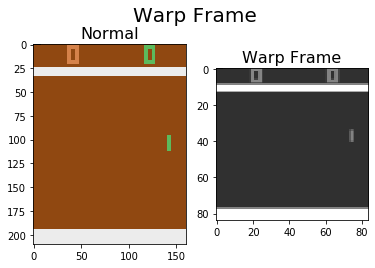

In [10]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [11]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

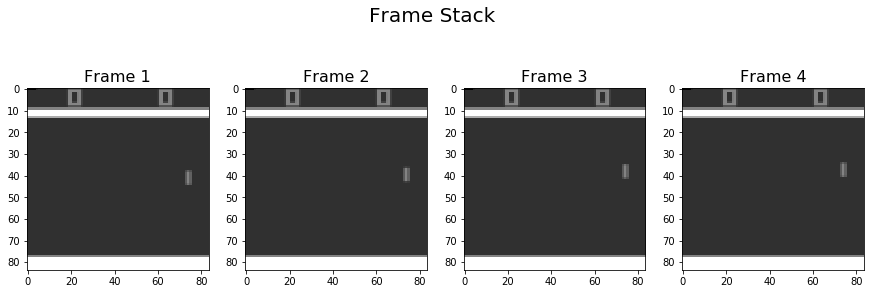

In [12]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
plt.show()

### Erstellen des Environments

In [13]:
def make_env(env_name):
    env = gym.make(env_name)
    env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [14]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = Huber()################################################################### MSE probieren
OPTIMIZER = RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01) # Adam probieren mit 0.00005#############################

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [15]:
DQN.summary(), TARGET.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0     

(None, None)

# **Memory Buffer**

In [16]:
MEMORY_SIZE = 1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [17]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [18]:
EPSILON = 1.0
EPSILON_MIN = 0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [19]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

-17.0

# **Training des Agenten**

In [28]:
from datetime import datetime
start_time = datetime.now()

EPISODES = 15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
EPSILON_LIST = []
STEPS = 0
SYNC = 10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward

        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            #EPSILON_STEP = (EPSILON - EPSILON_MIN) / EPSILON_STEPS
            #EPSILON -= EPSILON_STEP
            EPSILON -= EPSILON_DECAY


        # State aktualisieren
        state = next_state
        STEPS += 1

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2), "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    PATH = "WEIGHTS"
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"/" + game + "_DQN"+ "_Ep_"+ str(episode+1)+ ".h5")
                    TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_Ep_"+ str(episode+1)+ ".h5")
                    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Episode: 1 	Reward: -20.0 	Mean: -20.0 	TRAIN START: False 	Epsi: 0.9995599000000145
Episode: 2 	Reward: -20.0 	Mean: -20.0 	TRAIN START: False 	Epsi: 0.9993529000000213
Episode: 3 	Reward: -20.0 	Mean: -20.0 	TRAIN START: False 	Epsi: 0.9990442000000315
Episode: 4 	Reward: -21.0 	Mean: -20.25 	TRAIN START: False 	Epsi: 0.9988336000000384
Episode: 5 	Reward: -21.0 	Mean: -20.4 	TRAIN START: False 	Epsi: 0.9985681000000471
Episode: 6 	Reward: -21.0 	Mean: -20.5 	TRAIN START: False 	Epsi: 0.9982792000000567
Episode: 7 	Reward: -20.0 	Mean: -20.43 	TRAIN START: False 	Epsi: 0.9980299000000649
Episode: 8 	Reward: -20.0 	Mean: -20.38 	TRAIN START: False 	Epsi: 0.9977464000000742
Episode: 9 	Reward: -21.0 	Mean: -20.44 	TRAIN START: False 	Epsi: 0.9974827000000829
Episode: 10 	Reward: -21.0 	Mean: -20.5 	TRAIN START: False 	Epsi: 0.9972496000000906
Episode: 11 	Reward: -20.0 	Mean: -20.5 	TRAIN START: False 	Epsi: 0.9969895000000991
Episode: 12 	Reward: -20.0 	Mean: -20.5 	TRAIN START: False

Episode: 97 	Reward: -20.0 	Mean: -19.9 	TRAIN START: False 	Epsi: 0.9745426000008381
Episode: 98 	Reward: -21.0 	Mean: -19.9 	TRAIN START: False 	Epsi: 0.9742780000008469
Episode: 99 	Reward: -19.0 	Mean: -19.9 	TRAIN START: False 	Epsi: 0.9740098000008557
Episode: 100 	Reward: -20.0 	Mean: -19.9 	TRAIN START: False 	Epsi: 0.9737641000008638
Episode: 101 	Reward: -20.0 	Mean: -19.8 	TRAIN START: False 	Epsi: 0.973484200000873
Episode: 102 	Reward: -21.0 	Mean: -20.0 	TRAIN START: False 	Epsi: 0.973240300000881
Episode: 103 	Reward: -19.0 	Mean: -19.9 	TRAIN START: False 	Epsi: 0.9730018000008889
Episode: 104 	Reward: -20.0 	Mean: -19.9 	TRAIN START: False 	Epsi: 0.9727597000008968
Episode: 105 	Reward: -21.0 	Mean: -20.0 	TRAIN START: False 	Epsi: 0.9725311000009044
Episode: 106 	Reward: -20.0 	Mean: -20.1 	TRAIN START: False 	Epsi: 0.972238600000914
Episode: 107 	Reward: -20.0 	Mean: -20.1 	TRAIN START: False 	Epsi: 0.9720082000009216
Episode: 108 	Reward: -20.0 	Mean: -20.0 	TRAIN S

W1209 07:42:28.460822 140697589249856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1393: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1209 07:42:28.527424 140697589249856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 173 	Reward: -21.0 	Mean: -20.2 	TRAIN START: True 	Epsi: 0.9549046000014847
Episode: 174 	Reward: -19.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.9545743000014956
Episode: 175 	Reward: -20.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.9542764000015054
Episode: 176 	Reward: -20.0 	Mean: -20.2 	TRAIN START: True 	Epsi: 0.9540604000015125
Episode: 177 	Reward: -20.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.9538588000015191
Episode: 178 	Reward: -21.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.9536005000015276
Episode: 179 	Reward: -20.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.9533962000015344
Episode: 180 	Reward: -21.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.953132500001543
Episode: 181 	Reward: -19.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.9528769000015515
Episode: 182 	Reward: -21.0 	Mean: -20.2 	TRAIN START: True 	Epsi: 0.95261590000156
Episode: 183 	Reward: -21.0 	Mean: -20.2 	TRAIN START: True 	Epsi: 0.9523936000015674
Episode: 184 	Reward: -19.0 	Mean: -20.2 	TRAIN START: Tr

Episode: 269 	Reward: -20.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.9292924000023279
Episode: 270 	Reward: -20.0 	Mean: -19.9 	TRAIN START: True 	Epsi: 0.9290422000023362
Episode: 271 	Reward: -21.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.9288001000023441
Episode: 272 	Reward: -20.0 	Mean: -20.2 	TRAIN START: True 	Epsi: 0.9285562000023522
Episode: 273 	Reward: -20.0 	Mean: -20.3 	TRAIN START: True 	Epsi: 0.9282214000023632
Episode: 274 	Reward: -20.0 	Mean: -20.3 	TRAIN START: True 	Epsi: 0.9279469000023722
Episode: 275 	Reward: -19.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.9275491000023853
Episode: 276 	Reward: -17.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.9272476000023953
Episode: 277 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.9269875000024038
Episode: 278 	Reward: -21.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.9267445000024118
Episode: 279 	Reward: -21.0 	Mean: -19.9 	TRAIN START: True 	Epsi: 0.9265096000024196
Episode: 280 	Reward: -19.0 	Mean: -19.8 	TRAIN START:

Episode: 365 	Reward: -21.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.9032545000031852
Episode: 366 	Reward: -20.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.9030349000031924
Episode: 367 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.9027928000032004
Episode: 368 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.9025129000032096
Episode: 369 	Reward: -21.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.902288800003217
Episode: 370 	Reward: -20.0 	Mean: -19.9 	TRAIN START: True 	Epsi: 0.9020710000032242
Episode: 371 	Reward: -19.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.9017596000032344
Episode: 372 	Reward: -18.0 	Mean: -19.9 	TRAIN START: True 	Epsi: 0.9014473000032447
Episode: 373 	Reward: -21.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.9011791000032535
Episode: 374 	Reward: -19.0 	Mean: -19.9 	TRAIN START: True 	Epsi: 0.9008758000032635
Episode: 375 	Reward: -19.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.900586000003273
Episode: 376 	Reward: -20.0 	Mean: -19.7 	TRAIN START: T

Episode: 461 	Reward: -19.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.8773138000040392
Episode: 462 	Reward: -19.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.8770339000040485
Episode: 463 	Reward: -18.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.8766712000040604
Episode: 464 	Reward: -21.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.8763958000040695
Episode: 465 	Reward: -21.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.8761717000040768
Episode: 466 	Reward: -20.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.875863900004087
Episode: 467 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.8756173000040951
Episode: 468 	Reward: -19.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.8753689000041033
Episode: 469 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.8751187000041115
Episode: 470 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.8748847000041192
Episode: 471 	Reward: -19.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.8745706000041296
Episode: 472 	Reward: -21.0 	Mean: -19.9 	TRAIN START: 

Episode: 557 	Reward: -20.0 	Mean: -19.9 	TRAIN START: True 	Epsi: 0.8511130000049019
Episode: 558 	Reward: -21.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.8508331000049111
Episode: 559 	Reward: -18.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.850531600004921
Episode: 560 	Reward: -20.0 	Mean: -20.2 	TRAIN START: True 	Epsi: 0.8502085000049316
Episode: 561 	Reward: -19.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.849925900004941
Episode: 562 	Reward: -20.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.8496415000049503
Episode: 563 	Reward: -21.0 	Mean: -20.2 	TRAIN START: True 	Epsi: 0.8493985000049583
Episode: 564 	Reward: -20.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.8491069000049679
Episode: 565 	Reward: -21.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.8488387000049767
Episode: 566 	Reward: -20.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.8485291000049869
Episode: 567 	Reward: -20.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.8482492000049962
Episode: 568 	Reward: -18.0 	Mean: -19.7 	TRAIN START: T

Episode: 653 	Reward: -19.0 	Mean: -19.9 	TRAIN START: True 	Epsi: 0.8229502000058291
Episode: 654 	Reward: -20.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.8227486000058357
Episode: 655 	Reward: -20.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.8224714000058448
Episode: 656 	Reward: -20.0 	Mean: -20.1 	TRAIN START: True 	Epsi: 0.8222140000058533
Episode: 657 	Reward: -21.0 	Mean: -20.2 	TRAIN START: True 	Epsi: 0.821918800005863
Episode: 658 	Reward: -19.0 	Mean: -20.0 	TRAIN START: True 	Epsi: 0.8216263000058727
Episode: 659 	Reward: -19.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.8212933000058836
Episode: 660 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.8210593000058913
Episode: 661 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.820766800005901
Episode: 662 	Reward: -20.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.8205409000059084
Episode: 663 	Reward: -17.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.820217800005919
Episode: 664 	Reward: -21.0 	Mean: -19.7 	TRAIN START: Tr

Episode: 749 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.794917000006752
Episode: 750 	Reward: -21.0 	Mean: -19.9 	TRAIN START: True 	Epsi: 0.7946713000067601
Episode: 751 	Reward: -18.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.7943266000067715
Episode: 752 	Reward: -19.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.794005300006782
Episode: 753 	Reward: -19.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7936858000067926
Episode: 754 	Reward: -20.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.7933780000068027
Episode: 755 	Reward: -20.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.7930585000068132
Episode: 756 	Reward: -19.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7928083000068215
Episode: 757 	Reward: -20.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.7925383000068303
Episode: 758 	Reward: -18.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.7922278000068406
Episode: 759 	Reward: -18.0 	Mean: -19.2 	TRAIN START: True 	Epsi: 0.7918309000068536
Episode: 760 	Reward: -18.0 	Mean: -18.9 	TRAIN START: T

Episode: 845 	Reward: -18.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.7659676000077051
Episode: 846 	Reward: -20.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7656535000077155
Episode: 847 	Reward: -21.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.7653700000077248
Episode: 848 	Reward: -18.0 	Mean: -19.3 	TRAIN START: True 	Epsi: 0.7650433000077356
Episode: 849 	Reward: -18.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.7647148000077464
Episode: 850 	Reward: -19.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.7643872000077572
Episode: 851 	Reward: -19.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7640794000077673
Episode: 852 	Reward: -20.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.7638616000077745
Episode: 853 	Reward: -20.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.7635349000077852
Episode: 854 	Reward: -19.0 	Mean: -19.2 	TRAIN START: True 	Epsi: 0.763239700007795
Episode: 855 	Reward: -18.0 	Mean: -19.2 	TRAIN START: True 	Epsi: 0.7629382000078049
Episode: 856 	Reward: -20.0 	Mean: -19.2 	TRAIN START: 

Episode: 941 	Reward: -19.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.7360777000086892
Episode: 942 	Reward: -19.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7357573000086998
Episode: 943 	Reward: -21.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.7354684000087093
Episode: 944 	Reward: -18.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7350571000087228
Episode: 945 	Reward: -19.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.7347637000087325
Episode: 946 	Reward: -21.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.7345018000087411
Episode: 947 	Reward: -21.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.7342822000087483
Episode: 948 	Reward: -18.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7339015000087609
Episode: 949 	Reward: -20.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7336018000087707
Episode: 950 	Reward: -21.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.7333561000087788
Episode: 951 	Reward: -19.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.7330186000087899
Episode: 952 	Reward: -19.0 	Mean: -19.7 	TRAIN START:

Episode: 1036 	Reward: -20.0 	Mean: -19.8 	TRAIN START: True 	Epsi: 0.7066018000096597
Episode: 1037 	Reward: -19.0 	Mean: -19.7 	TRAIN START: True 	Epsi: 0.7062751000096704
Episode: 1038 	Reward: -19.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.7059781000096802
Episode: 1039 	Reward: -18.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.7055929000096929
Episode: 1040 	Reward: -21.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.7053094000097022
Episode: 1041 	Reward: -18.0 	Mean: -19.2 	TRAIN START: True 	Epsi: 0.704953000009714
Episode: 1042 	Reward: -17.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.7046137000097251
Episode: 1043 	Reward: -20.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.7042573000097369
Episode: 1044 	Reward: -19.0 	Mean: -19.0 	TRAIN START: True 	Epsi: 0.7039090000097483
Episode: 1045 	Reward: -19.0 	Mean: -19.0 	TRAIN START: True 	Epsi: 0.703615600009758
Episode: 1046 	Reward: -18.0 	Mean: -18.8 	TRAIN START: True 	Epsi: 0.7032664000097695
Episode: 1047 	Reward: -20.0 	Mean: -18.9 	TR

Episode: 1131 	Reward: -16.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.6747013000107099
Episode: 1132 	Reward: -19.0 	Mean: -18.2 	TRAIN START: True 	Epsi: 0.6743242000107224
Episode: 1133 	Reward: -21.0 	Mean: -18.5 	TRAIN START: True 	Epsi: 0.6740713000107307
Episode: 1134 	Reward: -17.0 	Mean: -18.2 	TRAIN START: True 	Epsi: 0.6736195000107456
Episode: 1135 	Reward: -20.0 	Mean: -18.4 	TRAIN START: True 	Epsi: 0.6733432000107547
Episode: 1136 	Reward: -20.0 	Mean: -18.3 	TRAIN START: True 	Epsi: 0.6730804000107633
Episode: 1137 	Reward: -20.0 	Mean: -18.5 	TRAIN START: True 	Epsi: 0.672814900010772
Episode: 1138 	Reward: -19.0 	Mean: -18.5 	TRAIN START: True 	Epsi: 0.6724747000107832
Episode: 1139 	Reward: -18.0 	Mean: -18.5 	TRAIN START: True 	Epsi: 0.6720949000107957
Episode: 1140 	Reward: -19.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.671752000010807
Episode: 1141 	Reward: -21.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.6714541000108168
Episode: 1142 	Reward: -20.0 	Mean: -19.5 	TR

Episode: 1226 	Reward: -21.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.6431599000117484
Episode: 1227 	Reward: -18.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.6428323000117592
Episode: 1228 	Reward: -18.0 	Mean: -19.2 	TRAIN START: True 	Epsi: 0.6424795000117708
Episode: 1229 	Reward: -17.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.6421231000117825
Episode: 1230 	Reward: -20.0 	Mean: -19.0 	TRAIN START: True 	Epsi: 0.6417649000117943
Episode: 1231 	Reward: -19.0 	Mean: -19.1 	TRAIN START: True 	Epsi: 0.6414364000118051
Episode: 1232 	Reward: -18.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.6410719000118171
Episode: 1233 	Reward: -19.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.6407002000118294
Episode: 1234 	Reward: -18.0 	Mean: -18.8 	TRAIN START: True 	Epsi: 0.6403816000118399
Episode: 1235 	Reward: -20.0 	Mean: -18.8 	TRAIN START: True 	Epsi: 0.6401008000118491
Episode: 1236 	Reward: -19.0 	Mean: -18.6 	TRAIN START: True 	Epsi: 0.6397813000118596
Episode: 1237 	Reward: -18.0 	Mean: -18.6 	

Episode: 1321 	Reward: -19.0 	Mean: -19.1 	TRAIN START: True 	Epsi: 0.6101344000128357
Episode: 1322 	Reward: -20.0 	Mean: -19.3 	TRAIN START: True 	Epsi: 0.6097456000128485
Episode: 1323 	Reward: -17.0 	Mean: -19.1 	TRAIN START: True 	Epsi: 0.6093586000128612
Episode: 1324 	Reward: -21.0 	Mean: -19.4 	TRAIN START: True 	Epsi: 0.6090229000128723
Episode: 1325 	Reward: -20.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.6087907000128799
Episode: 1326 	Reward: -18.0 	Mean: -19.6 	TRAIN START: True 	Epsi: 0.6084172000128922
Episode: 1327 	Reward: -19.0 	Mean: -19.5 	TRAIN START: True 	Epsi: 0.6080563000129041
Episode: 1328 	Reward: -17.0 	Mean: -19.3 	TRAIN START: True 	Epsi: 0.6076756000129167
Episode: 1329 	Reward: -20.0 	Mean: -19.2 	TRAIN START: True 	Epsi: 0.6072481000129307
Episode: 1330 	Reward: -18.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.6069250000129414
Episode: 1331 	Reward: -21.0 	Mean: -19.1 	TRAIN START: True 	Epsi: 0.606571300012953
Episode: 1332 	Reward: -19.0 	Mean: -19.0 	T

Episode: 1416 	Reward: -15.0 	Mean: -18.4 	TRAIN START: True 	Epsi: 0.5760136000139591
Episode: 1417 	Reward: -16.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.5755816000139733
Episode: 1418 	Reward: -21.0 	Mean: -18.2 	TRAIN START: True 	Epsi: 0.5752909000139829
Episode: 1419 	Reward: -19.0 	Mean: -18.3 	TRAIN START: True 	Epsi: 0.5748724000139966
Episode: 1420 	Reward: -21.0 	Mean: -18.7 	TRAIN START: True 	Epsi: 0.574588900014006
Episode: 1421 	Reward: -20.0 	Mean: -18.8 	TRAIN START: True 	Epsi: 0.5742730000140164
Episode: 1422 	Reward: -19.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.5738869000140291
Episode: 1423 	Reward: -16.0 	Mean: -18.5 	TRAIN START: True 	Epsi: 0.5734837000140424
Episode: 1424 	Reward: -17.0 	Mean: -18.2 	TRAIN START: True 	Epsi: 0.5730724000140559
Episode: 1425 	Reward: -19.0 	Mean: -18.3 	TRAIN START: True 	Epsi: 0.5726935000140684
Episode: 1426 	Reward: -20.0 	Mean: -18.8 	TRAIN START: True 	Epsi: 0.5723515000140796
Episode: 1427 	Reward: -19.0 	Mean: -19.1 	T

Episode: 1511 	Reward: -18.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.5402584000151363
Episode: 1512 	Reward: -18.0 	Mean: -17.7 	TRAIN START: True 	Epsi: 0.5398264000151505
Episode: 1513 	Reward: -19.0 	Mean: -17.8 	TRAIN START: True 	Epsi: 0.5394601000151625
Episode: 1514 	Reward: -17.0 	Mean: -17.9 	TRAIN START: True 	Epsi: 0.5390875000151748
Episode: 1515 	Reward: -17.0 	Mean: -17.7 	TRAIN START: True 	Epsi: 0.5387329000151865
Episode: 1516 	Reward: -20.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.5383936000151976
Episode: 1517 	Reward: -17.0 	Mean: -17.8 	TRAIN START: True 	Epsi: 0.5378464000152157
Episode: 1518 	Reward: -21.0 	Mean: -18.2 	TRAIN START: True 	Epsi: 0.5375863000152242
Episode: 1519 	Reward: -15.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.5371426000152388
Episode: 1520 	Reward: -18.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.5368321000152491
Episode: 1521 	Reward: -18.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.5364577000152614
Episode: 1522 	Reward: -12.0 	Mean: -17.4 	

Episode: 1606 	Reward: -16.0 	Mean: -17.4 	TRAIN START: True 	Epsi: 0.5033746000163506
Episode: 1607 	Reward: -17.0 	Mean: -17.3 	TRAIN START: True 	Epsi: 0.5029219000163655
Episode: 1608 	Reward: -20.0 	Mean: -17.6 	TRAIN START: True 	Epsi: 0.5025376000163781
Episode: 1609 	Reward: -17.0 	Mean: -17.7 	TRAIN START: True 	Epsi: 0.5021011000163925
Episode: 1610 	Reward: -17.0 	Mean: -17.4 	TRAIN START: True 	Epsi: 0.5016664000164068
Episode: 1611 	Reward: -17.0 	Mean: -17.2 	TRAIN START: True 	Epsi: 0.501237100016421
Episode: 1612 	Reward: -19.0 	Mean: -17.1 	TRAIN START: True 	Epsi: 0.500872600016433
Episode: 1613 	Reward: -18.0 	Mean: -17.4 	TRAIN START: True 	Epsi: 0.5004820000164458
Episode: 1614 	Reward: -14.0 	Mean: -17.0 	TRAIN START: True 	Epsi: 0.49998250001646116
Episode: 1615 	Reward: -14.0 	Mean: -16.9 	TRAIN START: True 	Epsi: 0.4994857000164469
Episode: 1616 	Reward: -20.0 	Mean: -17.3 	TRAIN START: True 	Epsi: 0.4990213000164335
Episode: 1617 	Reward: -18.0 	Mean: -17.4 	T

Episode: 1700 	Reward: -19.0 	Mean: -18.1 	TRAIN START: True 	Epsi: 0.46405900001542816
Episode: 1701 	Reward: -19.0 	Mean: -18.5 	TRAIN START: True 	Epsi: 0.4636459000154163
Episode: 1702 	Reward: -19.0 	Mean: -18.4 	TRAIN START: True 	Epsi: 0.4633264000154071
Episode: 1703 	Reward: -19.0 	Mean: -18.7 	TRAIN START: True 	Epsi: 0.4629268000153956
Episode: 1704 	Reward: -18.0 	Mean: -18.7 	TRAIN START: True 	Epsi: 0.4624741000153826
Episode: 1705 	Reward: -21.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.4621591000153735
Episode: 1706 	Reward: -19.0 	Mean: -18.9 	TRAIN START: True 	Epsi: 0.4617100000153606
Episode: 1707 	Reward: -20.0 	Mean: -19.2 	TRAIN START: True 	Epsi: 0.46134910001535023
Episode: 1708 	Reward: -19.0 	Mean: -19.1 	TRAIN START: True 	Epsi: 0.46091080001533763
Episode: 1709 	Reward: -18.0 	Mean: -19.1 	TRAIN START: True 	Epsi: 0.46051480001532624
Episode: 1710 	Reward: -19.0 	Mean: -19.1 	TRAIN START: True 	Epsi: 0.46004860001531284
Episode: 1711 	Reward: -18.0 	Mean: -1

Episode: 1794 	Reward: -19.0 	Mean: -18.1 	TRAIN START: True 	Epsi: 0.423679600014267
Episode: 1795 	Reward: -16.0 	Mean: -17.8 	TRAIN START: True 	Epsi: 0.42311440001425077
Episode: 1796 	Reward: -19.0 	Mean: -18.3 	TRAIN START: True 	Epsi: 0.4226455000142373
Episode: 1797 	Reward: -18.0 	Mean: -18.1 	TRAIN START: True 	Epsi: 0.4221424000142228
Episode: 1798 	Reward: -17.0 	Mean: -18.1 	TRAIN START: True 	Epsi: 0.42166720001420915
Episode: 1799 	Reward: -17.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.42116590001419474
Episode: 1800 	Reward: -19.0 	Mean: -18.0 	TRAIN START: True 	Epsi: 0.4208212000141848
Episode: 1801 	Reward: -16.0 	Mean: -17.8 	TRAIN START: True 	Epsi: 0.4203712000141719
Episode: 1802 	Reward: -15.0 	Mean: -17.6 	TRAIN START: True 	Epsi: 0.41995270001415985
Episode: 1803 	Reward: -18.0 	Mean: -17.4 	TRAIN START: True 	Epsi: 0.419505400014147
Episode: 1804 	Reward: -18.0 	Mean: -17.3 	TRAIN START: True 	Epsi: 0.4190599000141342
Episode: 1805 	Reward: -19.0 	Mean: -17.6

Episode: 1888 	Reward: -20.0 	Mean: -18.5 	TRAIN START: True 	Epsi: 0.3807208000130317
Episode: 1889 	Reward: -18.0 	Mean: -18.5 	TRAIN START: True 	Epsi: 0.38026000001301846
Episode: 1890 	Reward: -13.0 	Mean: -17.9 	TRAIN START: True 	Epsi: 0.3795895000129992
Episode: 1891 	Reward: -19.0 	Mean: -17.8 	TRAIN START: True 	Epsi: 0.37921960001298854
Episode: 1892 	Reward: -17.0 	Mean: -17.6 	TRAIN START: True 	Epsi: 0.37875790001297527
Episode: 1893 	Reward: -21.0 	Mean: -17.9 	TRAIN START: True 	Epsi: 0.3784501000129664
Episode: 1894 	Reward: -16.0 	Mean: -17.5 	TRAIN START: True 	Epsi: 0.3779767000129528
Episode: 1895 	Reward: -16.0 	Mean: -17.7 	TRAIN START: True 	Epsi: 0.3775141000129395
Episode: 1896 	Reward: -16.0 	Mean: -17.5 	TRAIN START: True 	Epsi: 0.37703890001292584
Episode: 1897 	Reward: -16.0 	Mean: -17.2 	TRAIN START: True 	Epsi: 0.3764980000129103
Episode: 1898 	Reward: -15.0 	Mean: -16.7 	TRAIN START: True 	Epsi: 0.37609030001289856
Episode: 1899 	Reward: -18.0 	Mean: -1

Episode: 1982 	Reward: -14.0 	Mean: -17.2 	TRAIN START: True 	Epsi: 0.33522220001172337
Episode: 1983 	Reward: -17.0 	Mean: -17.0 	TRAIN START: True 	Epsi: 0.3347686000117103
Episode: 1984 	Reward: -13.0 	Mean: -16.6 	TRAIN START: True 	Epsi: 0.3340729000116903
Episode: 1985 	Reward: -18.0 	Mean: -16.4 	TRAIN START: True 	Epsi: 0.3336661000116786
Episode: 1986 	Reward: -19.0 	Mean: -16.4 	TRAIN START: True 	Epsi: 0.33305770001166113
Episode: 1987 	Reward: -18.0 	Mean: -16.5 	TRAIN START: True 	Epsi: 0.33262750001164876
Episode: 1988 	Reward: -19.0 	Mean: -16.9 	TRAIN START: True 	Epsi: 0.3321361000116346
Episode: 1989 	Reward: -16.0 	Mean: -16.8 	TRAIN START: True 	Epsi: 0.33161230001161957
Episode: 1990 	Reward: -18.0 	Mean: -17.0 	TRAIN START: True 	Epsi: 0.33101020001160225
Episode: 1991 	Reward: -19.0 	Mean: -17.1 	TRAIN START: True 	Epsi: 0.33047110001158675
Episode: 1992 	Reward: -14.0 	Mean: -17.1 	TRAIN START: True 	Epsi: 0.32992570001157107
Episode: 1993 	Reward: -17.0 	Mean: 

Episode: 2076 	Reward: -16.0 	Mean: -17.0 	TRAIN START: True 	Epsi: 0.2856475000102978
Episode: 2077 	Reward: -19.0 	Mean: -17.3 	TRAIN START: True 	Epsi: 0.28505710001028084
Episode: 2078 	Reward: -17.0 	Mean: -17.0 	TRAIN START: True 	Epsi: 0.28454950001026624
Episode: 2079 	Reward: -15.0 	Mean: -16.7 	TRAIN START: True 	Epsi: 0.28388530001024714
Episode: 2080 	Reward: -18.0 	Mean: -16.6 	TRAIN START: True 	Epsi: 0.2833858000102328
Episode: 2081 	Reward: -15.0 	Mean: -16.6 	TRAIN START: True 	Epsi: 0.28279000001021565
Episode: 2082 	Reward: -18.0 	Mean: -16.7 	TRAIN START: True 	Epsi: 0.28233820001020266
Episode: 2083 	Reward: -18.0 	Mean: -17.2 	TRAIN START: True 	Epsi: 0.28190350001019016
Episode: 2084 	Reward: -17.0 	Mean: -17.0 	TRAIN START: True 	Epsi: 0.28124200001017113
Episode: 2085 	Reward: -20.0 	Mean: -17.3 	TRAIN START: True 	Epsi: 0.2807704000101576
Episode: 2086 	Reward: -19.0 	Mean: -17.6 	TRAIN START: True 	Epsi: 0.2803015000101441
Episode: 2087 	Reward: -15.0 	Mean: 

Episode: 2170 	Reward: -16.0 	Mean: -16.7 	TRAIN START: True 	Epsi: 0.2324656000093093
Episode: 2171 	Reward: -18.0 	Mean: -16.6 	TRAIN START: True 	Epsi: 0.23191390000931045
Episode: 2172 	Reward: -16.0 	Mean: -16.2 	TRAIN START: True 	Epsi: 0.23124970000931183
Episode: 2173 	Reward: -14.0 	Mean: -15.6 	TRAIN START: True 	Epsi: 0.23045590000931349
Episode: 2174 	Reward: -14.0 	Mean: -15.7 	TRAIN START: True 	Epsi: 0.22969990000931506
Episode: 2175 	Reward: -11.0 	Mean: -15.6 	TRAIN START: True 	Epsi: 0.22885840000931681
Episode: 2176 	Reward: -12.0 	Mean: -15.0 	TRAIN START: True 	Epsi: 0.22808170000931843
Episode: 2177 	Reward: -15.0 	Mean: -15.2 	TRAIN START: True 	Epsi: 0.22741750000931982
Episode: 2178 	Reward: -18.0 	Mean: -15.1 	TRAIN START: True 	Epsi: 0.2270386000093206
Episode: 2179 	Reward: -15.0 	Mean: -14.9 	TRAIN START: True 	Epsi: 0.226369000009322
Episode: 2180 	Reward: -15.0 	Mean: -14.8 	TRAIN START: True 	Epsi: 0.22561840000932357
Episode: 2181 	Reward: -11.0 	Mean: 

Episode: 2264 	Reward: -13.0 	Mean: -16.0 	TRAIN START: True 	Epsi: 0.1740115000094311
Episode: 2265 	Reward: -18.0 	Mean: -16.5 	TRAIN START: True 	Epsi: 0.1734454000094323
Episode: 2266 	Reward: -20.0 	Mean: -16.8 	TRAIN START: True 	Epsi: 0.17298280000943325
Episode: 2267 	Reward: -12.0 	Mean: -16.3 	TRAIN START: True 	Epsi: 0.17230420000943467
Episode: 2268 	Reward: -19.0 	Mean: -16.6 	TRAIN START: True 	Epsi: 0.17172820000943587
Episode: 2269 	Reward: -15.0 	Mean: -16.4 	TRAIN START: True 	Epsi: 0.17100370000943738
Episode: 2270 	Reward: -18.0 	Mean: -16.3 	TRAIN START: True 	Epsi: 0.17045020000943853
Episode: 2271 	Reward: -16.0 	Mean: -16.3 	TRAIN START: True 	Epsi: 0.16965640000944018
Episode: 2272 	Reward: -19.0 	Mean: -16.5 	TRAIN START: True 	Epsi: 0.16924240000944105
Episode: 2273 	Reward: -10.0 	Mean: -16.0 	TRAIN START: True 	Epsi: 0.16850710000944258
Episode: 2274 	Reward: -14.0 	Mean: -16.1 	TRAIN START: True 	Epsi: 0.16759990000944447
Episode: 2275 	Reward: -13.0 	Mean

Episode: 2358 	Reward: -13.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.10914400000956628
Episode: 2359 	Reward: -16.0 	Mean: -14.5 	TRAIN START: True 	Epsi: 0.10833580000956797
Episode: 2360 	Reward: -16.0 	Mean: -14.7 	TRAIN START: True 	Epsi: 0.1076032000095695
Episode: 2361 	Reward: -16.0 	Mean: -14.6 	TRAIN START: True 	Epsi: 0.10680670000957115
Episode: 2362 	Reward: -14.0 	Mean: -15.2 	TRAIN START: True 	Epsi: 0.1061101000095726
Episode: 2363 	Reward: -16.0 	Mean: -15.4 	TRAIN START: True 	Epsi: 0.10551250000957385
Episode: 2364 	Reward: -8.0 	Mean: -14.6 	TRAIN START: True 	Epsi: 0.10438120000957621
Episode: 2365 	Reward: -17.0 	Mean: -15.0 	TRAIN START: True 	Epsi: 0.10384120000957733
Episode: 2366 	Reward: -13.0 	Mean: -14.7 	TRAIN START: True 	Epsi: 0.103041100009579
Episode: 2367 	Reward: -8.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.10214740000958086
Episode: 2368 	Reward: -9.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.1010773000095831
Episode: 2369 	Reward: -17.0 	Mean: -13.

Episode: 2452 	Reward: -16.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2453 	Reward: -10.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2454 	Reward: -9.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2455 	Reward: -18.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2456 	Reward: -18.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2457 	Reward: -14.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2458 	Reward: -15.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2459 	Reward: -10.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2460 	Reward: -14.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2461 	Reward: -16.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2462 	Reward: -8.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2463 	Reward: -14.0 	Mean

Episode: 2546 	Reward: -15.0 	Mean: -14.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2547 	Reward: -9.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2548 	Reward: -13.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2549 	Reward: -16.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2550 	Reward: -16.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2551 	Reward: -14.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2552 	Reward: -14.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2553 	Reward: -10.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2554 	Reward: -14.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2555 	Reward: -13.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2556 	Reward: -13.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2557 	Reward: -15.0 	Mea

Episode: 2640 	Reward: -15.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2641 	Reward: -14.0 	Mean: -14.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2642 	Reward: -16.0 	Mean: -14.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2643 	Reward: -16.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2644 	Reward: -16.0 	Mean: -14.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2645 	Reward: -14.0 	Mean: -14.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2646 	Reward: -15.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2647 	Reward: -12.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2648 	Reward: -16.0 	Mean: -14.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2649 	Reward: -19.0 	Mean: -15.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2650 	Reward: -14.0 	Mean: -15.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2651 	Reward: -11.0 	Me

Episode: 2734 	Reward: -14.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2735 	Reward: -13.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2736 	Reward: -17.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2737 	Reward: -11.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2738 	Reward: -13.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2739 	Reward: -18.0 	Mean: -14.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2740 	Reward: -15.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2741 	Reward: -7.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2742 	Reward: -14.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2743 	Reward: -11.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2744 	Reward: -10.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2745 	Reward: -19.0 	Mea

Episode: 2828 	Reward: -14.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2829 	Reward: -10.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2830 	Reward: -5.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2831 	Reward: -15.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2832 	Reward: -12.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2833 	Reward: -15.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2834 	Reward: -15.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2835 	Reward: -12.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2836 	Reward: -14.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2837 	Reward: -8.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2838 	Reward: -14.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2839 	Reward: -8.0 	Mean:

Episode: 2922 	Reward: -15.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2923 	Reward: -14.0 	Mean: -14.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2924 	Reward: -17.0 	Mean: -14.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2925 	Reward: -15.0 	Mean: -15.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2926 	Reward: -18.0 	Mean: -15.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2927 	Reward: -19.0 	Mean: -15.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2928 	Reward: -16.0 	Mean: -15.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2929 	Reward: -12.0 	Mean: -15.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2930 	Reward: -16.0 	Mean: -15.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2931 	Reward: -14.0 	Mean: -15.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2932 	Reward: -15.0 	Mean: -15.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 2933 	Reward: -13.0 	Me

Episode: 3016 	Reward: -10.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3017 	Reward: -13.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3018 	Reward: -15.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3019 	Reward: -18.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3020 	Reward: -10.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3021 	Reward: -14.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3022 	Reward: -12.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3023 	Reward: -12.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3024 	Reward: -10.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3025 	Reward: -11.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3026 	Reward: -14.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3027 	Reward: -16.0 	Me

Episode: 3110 	Reward: -11.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3111 	Reward: -18.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3112 	Reward: -18.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3113 	Reward: -13.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3114 	Reward: -16.0 	Mean: -14.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3115 	Reward: -18.0 	Mean: -14.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3116 	Reward: -10.0 	Mean: -14.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3117 	Reward: -11.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3118 	Reward: -18.0 	Mean: -14.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3119 	Reward: -14.0 	Mean: -14.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3120 	Reward: -13.0 	Mean: -14.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3121 	Reward: -4.0 	Mea

Episode: 3204 	Reward: -14.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3205 	Reward: -15.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3206 	Reward: -13.0 	Mean: -12.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3207 	Reward: -15.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3208 	Reward: -16.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3209 	Reward: -13.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3210 	Reward: -10.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3211 	Reward: -12.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3212 	Reward: -16.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3213 	Reward: -14.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3214 	Reward: -7.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3215 	Reward: -12.0 	Mea

Episode: 3298 	Reward: -17.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3299 	Reward: -14.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3300 	Reward: -14.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3301 	Reward: -14.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3302 	Reward: -10.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3303 	Reward: -13.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3304 	Reward: -7.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3305 	Reward: -9.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3306 	Reward: -15.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3307 	Reward: -12.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3308 	Reward: -12.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3309 	Reward: -10.0 	Mean

Episode: 3392 	Reward: -14.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3393 	Reward: -16.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3394 	Reward: -6.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3395 	Reward: -14.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3396 	Reward: -19.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3397 	Reward: -7.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3398 	Reward: -17.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3399 	Reward: -13.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3400 	Reward: -17.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3401 	Reward: -20.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3402 	Reward: -17.0 	Mean: -14.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3403 	Reward: -14.0 	Mean

Episode: 3486 	Reward: -12.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3487 	Reward: -8.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3488 	Reward: -11.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3489 	Reward: -6.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3490 	Reward: -16.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3491 	Reward: -13.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3492 	Reward: -11.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3493 	Reward: -14.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3494 	Reward: -18.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3495 	Reward: -13.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3496 	Reward: -17.0 	Mean: -12.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3497 	Reward: -15.0 	Mean

Episode: 3580 	Reward: -16.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3581 	Reward: -12.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3582 	Reward: -11.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3583 	Reward: -8.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3584 	Reward: -16.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3585 	Reward: -18.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3586 	Reward: -15.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3587 	Reward: -15.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3588 	Reward: -7.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3589 	Reward: -17.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3590 	Reward: -17.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3591 	Reward: -15.0 	Mean

Episode: 3674 	Reward: -16.0 	Mean: -12.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3675 	Reward: -12.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3676 	Reward: -14.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3677 	Reward: -11.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3678 	Reward: -10.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3679 	Reward: -11.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3680 	Reward: -19.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3681 	Reward: -17.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3682 	Reward: -14.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3683 	Reward: -13.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3684 	Reward: -15.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3685 	Reward: -8.0 	Mea

Episode: 3768 	Reward: -15.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3769 	Reward: -17.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3770 	Reward: -13.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3771 	Reward: -16.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3772 	Reward: -16.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3773 	Reward: -11.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3774 	Reward: -13.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3775 	Reward: -9.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3776 	Reward: -17.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3777 	Reward: -11.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3778 	Reward: -14.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3779 	Reward: -7.0 	Mean

Episode: 3862 	Reward: -10.0 	Mean: -10.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3863 	Reward: -10.0 	Mean: -9.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3864 	Reward: -11.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3865 	Reward: -17.0 	Mean: -10.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3866 	Reward: -11.0 	Mean: -10.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3867 	Reward: -14.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3868 	Reward: -10.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3869 	Reward: -11.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3870 	Reward: -14.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3871 	Reward: -13.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3872 	Reward: -18.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3873 	Reward: -14.0 	Mean

Episode: 3956 	Reward: -14.0 	Mean: -14.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3957 	Reward: -17.0 	Mean: -15.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3958 	Reward: -7.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3959 	Reward: -11.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3960 	Reward: -16.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3961 	Reward: -13.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3962 	Reward: -16.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3963 	Reward: -17.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3964 	Reward: -15.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3965 	Reward: -15.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3966 	Reward: -13.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 3967 	Reward: -11.0 	Mea

Episode: 4050 	Reward: -11.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4051 	Reward: -15.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4052 	Reward: -10.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4053 	Reward: -16.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4054 	Reward: -11.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4055 	Reward: -8.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4056 	Reward: -15.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4057 	Reward: -15.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4058 	Reward: -15.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4059 	Reward: -13.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4060 	Reward: -16.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4061 	Reward: -11.0 	Mea

Episode: 4144 	Reward: -19.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4145 	Reward: -11.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4146 	Reward: -15.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4147 	Reward: -18.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4148 	Reward: -15.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4149 	Reward: -13.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4150 	Reward: -13.0 	Mean: -14.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4151 	Reward: -12.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4152 	Reward: -13.0 	Mean: -14.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4153 	Reward: -14.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4154 	Reward: -13.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4155 	Reward: -8.0 	Mea

Episode: 4238 	Reward: -11.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4239 	Reward: -14.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4240 	Reward: -10.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4241 	Reward: -7.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4242 	Reward: -15.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4243 	Reward: -15.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4244 	Reward: -9.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4245 	Reward: -14.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4246 	Reward: -13.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4247 	Reward: -12.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4248 	Reward: -10.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4249 	Reward: -14.0 	Mean

Episode: 4332 	Reward: -9.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4333 	Reward: -12.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4334 	Reward: -17.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4335 	Reward: -11.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4336 	Reward: -12.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4337 	Reward: -8.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4338 	Reward: -8.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4339 	Reward: -15.0 	Mean: -11.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4340 	Reward: -9.0 	Mean: -10.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4341 	Reward: -10.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4342 	Reward: -11.0 	Mean: -11.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4343 	Reward: -9.0 	Mean: -

Episode: 4426 	Reward: -13.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4427 	Reward: -13.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4428 	Reward: -11.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4429 	Reward: -15.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4430 	Reward: -12.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4431 	Reward: -9.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4432 	Reward: -12.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4433 	Reward: -11.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4434 	Reward: -14.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4435 	Reward: -12.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4436 	Reward: -19.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4437 	Reward: -9.0 	Mean

Episode: 4520 	Reward: -12.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4521 	Reward: -15.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4522 	Reward: -17.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4523 	Reward: -13.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4524 	Reward: -12.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4525 	Reward: -9.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4526 	Reward: -15.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4527 	Reward: -17.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4528 	Reward: -7.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4529 	Reward: -16.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4530 	Reward: -11.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4531 	Reward: -10.0 	Mean

Episode: 4614 	Reward: -8.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4615 	Reward: -14.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4616 	Reward: -11.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4617 	Reward: -14.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4618 	Reward: -11.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4619 	Reward: -14.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4620 	Reward: -15.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4621 	Reward: -12.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4622 	Reward: -15.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4623 	Reward: -13.0 	Mean: -12.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4624 	Reward: -13.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4625 	Reward: -9.0 	Mean

Episode: 4708 	Reward: -8.0 	Mean: -10.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4709 	Reward: -6.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4710 	Reward: -15.0 	Mean: -10.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4711 	Reward: -15.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4712 	Reward: -12.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4713 	Reward: -15.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4714 	Reward: -16.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4715 	Reward: -16.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4716 	Reward: -10.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4717 	Reward: -17.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4718 	Reward: -18.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4719 	Reward: -15.0 	Mean:

Episode: 4802 	Reward: -11.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4803 	Reward: -12.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4804 	Reward: -14.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4805 	Reward: -14.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4806 	Reward: -15.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4807 	Reward: -14.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4808 	Reward: -18.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4809 	Reward: -16.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4810 	Reward: -16.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4811 	Reward: -13.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4812 	Reward: -10.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4813 	Reward: -14.0 	Me

Episode: 4896 	Reward: -16.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4897 	Reward: -10.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4898 	Reward: -12.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4899 	Reward: -13.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4900 	Reward: -12.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4901 	Reward: -15.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4902 	Reward: -12.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4903 	Reward: -12.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4904 	Reward: -13.0 	Mean: -12.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4905 	Reward: -16.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4906 	Reward: -13.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4907 	Reward: -16.0 	Me

Episode: 4990 	Reward: -11.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4991 	Reward: -18.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4992 	Reward: -10.0 	Mean: -13.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4993 	Reward: -15.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4994 	Reward: -16.0 	Mean: -14.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4995 	Reward: -12.0 	Mean: -14.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4996 	Reward: -15.0 	Mean: -14.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4997 	Reward: -18.0 	Mean: -14.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4998 	Reward: -13.0 	Mean: -14.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 4999 	Reward: -12.0 	Mean: -14.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5000 	Reward: -9.0 	Mean: -13.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5001 	Reward: -16.0 	Mea

Episode: 5084 	Reward: -11.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5085 	Reward: -10.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5086 	Reward: -14.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5087 	Reward: -13.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5088 	Reward: -14.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5089 	Reward: -3.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5090 	Reward: -15.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5091 	Reward: -9.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5092 	Reward: -12.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5093 	Reward: -13.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5094 	Reward: -13.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5095 	Reward: -12.0 	Mean

Episode: 5178 	Reward: -11.0 	Mean: -10.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5179 	Reward: -10.0 	Mean: -10.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5180 	Reward: -9.0 	Mean: -10.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5181 	Reward: -9.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5182 	Reward: -15.0 	Mean: -9.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5183 	Reward: -10.0 	Mean: -9.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5184 	Reward: -10.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5185 	Reward: -4.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5186 	Reward: -15.0 	Mean: -10.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5187 	Reward: -13.0 	Mean: -10.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5188 	Reward: -15.0 	Mean: -11.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5189 	Reward: -16.0 	Mean: -11.

Episode: 5272 	Reward: -10.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5273 	Reward: -12.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5274 	Reward: -15.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5275 	Reward: -16.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5276 	Reward: -17.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5277 	Reward: -8.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5278 	Reward: -20.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5279 	Reward: -17.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5280 	Reward: -12.0 	Mean: -14.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5281 	Reward: -9.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5282 	Reward: -10.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5283 	Reward: -3.0 	Mean:

Episode: 5366 	Reward: -11.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5367 	Reward: -13.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5368 	Reward: -8.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5369 	Reward: -15.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5370 	Reward: -11.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5371 	Reward: -8.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5372 	Reward: -12.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5373 	Reward: -11.0 	Mean: -11.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5374 	Reward: -9.0 	Mean: -11.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5375 	Reward: -16.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5376 	Reward: -12.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5377 	Reward: -12.0 	Mean:

Episode: 5460 	Reward: -11.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5461 	Reward: -9.0 	Mean: -12.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5462 	Reward: -18.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5463 	Reward: -10.0 	Mean: -12.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5464 	Reward: -10.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5465 	Reward: -15.0 	Mean: -13.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5466 	Reward: -11.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5467 	Reward: -11.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5468 	Reward: -16.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5469 	Reward: -10.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5470 	Reward: -12.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5471 	Reward: -13.0 	Mea

Episode: 5554 	Reward: -13.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5555 	Reward: -13.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5556 	Reward: -14.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5557 	Reward: -12.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5558 	Reward: -7.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5559 	Reward: -9.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5560 	Reward: -19.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5561 	Reward: -15.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5562 	Reward: -10.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5563 	Reward: -9.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5564 	Reward: -11.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5565 	Reward: -12.0 	Mean:

Episode: 5648 	Reward: -7.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5649 	Reward: -11.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5650 	Reward: -7.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5651 	Reward: -6.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5652 	Reward: -12.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5653 	Reward: -16.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5654 	Reward: -10.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5655 	Reward: -9.0 	Mean: -10.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5656 	Reward: -14.0 	Mean: -10.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5657 	Reward: -8.0 	Mean: -10.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5658 	Reward: -12.0 	Mean: -10.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5659 	Reward: -11.0 	Mean: -

Episode: 5742 	Reward: -5.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5743 	Reward: -4.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5744 	Reward: -17.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5745 	Reward: -16.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5746 	Reward: -12.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5747 	Reward: -12.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5748 	Reward: 2.0 	Mean: -10.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5749 	Reward: -15.0 	Mean: -10.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5750 	Reward: -16.0 	Mean: -10.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5751 	Reward: -15.0 	Mean: -11.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5752 	Reward: -14.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5753 	Reward: -16.0 	Mean: 

Episode: 5836 	Reward: -9.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5837 	Reward: -4.0 	Mean: -11.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5838 	Reward: -7.0 	Mean: -11.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5839 	Reward: -11.0 	Mean: -10.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5840 	Reward: -12.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5841 	Reward: -15.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5842 	Reward: -17.0 	Mean: -11.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5843 	Reward: -14.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5844 	Reward: -16.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5845 	Reward: -11.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5846 	Reward: -16.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5847 	Reward: -15.0 	Mean:

Episode: 5930 	Reward: -8.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5931 	Reward: -13.0 	Mean: -10.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5932 	Reward: -11.0 	Mean: -10.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5933 	Reward: -13.0 	Mean: -10.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5934 	Reward: -15.0 	Mean: -11.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5935 	Reward: -17.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5936 	Reward: -8.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5937 	Reward: -16.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5938 	Reward: -16.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5939 	Reward: -9.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5940 	Reward: -10.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 5941 	Reward: -12.0 	Mean: 

Episode: 6024 	Reward: -13.0 	Mean: -13.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6025 	Reward: -16.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6026 	Reward: -14.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6027 	Reward: -13.0 	Mean: -13.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6028 	Reward: -13.0 	Mean: -13.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6029 	Reward: -10.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6030 	Reward: -13.0 	Mean: -12.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6031 	Reward: -13.0 	Mean: -12.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6032 	Reward: -11.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6033 	Reward: -12.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6034 	Reward: -13.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6035 	Reward: -16.0 	Me

Episode: 6118 	Reward: -12.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6119 	Reward: -15.0 	Mean: -13.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6120 	Reward: -10.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6121 	Reward: -13.0 	Mean: -13.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6122 	Reward: -12.0 	Mean: -13.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6123 	Reward: -5.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6124 	Reward: -14.0 	Mean: -12.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6125 	Reward: -10.0 	Mean: -12.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6126 	Reward: -13.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6127 	Reward: -11.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6128 	Reward: -12.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6129 	Reward: -6.0 	Mean

Episode: 6212 	Reward: -11.0 	Mean: -9.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6213 	Reward: -9.0 	Mean: -9.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6214 	Reward: -7.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6215 	Reward: -6.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6216 	Reward: -9.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6217 	Reward: -13.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6218 	Reward: -5.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6219 	Reward: -10.0 	Mean: -9.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6220 	Reward: -17.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6221 	Reward: -10.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6222 	Reward: -17.0 	Mean: -10.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6223 	Reward: -12.0 	Mean: -10.6 	TRAI

Episode: 6306 	Reward: -6.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6307 	Reward: -12.0 	Mean: -10.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6308 	Reward: -10.0 	Mean: -10.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6309 	Reward: -10.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6310 	Reward: -1.0 	Mean: -10.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6311 	Reward: -15.0 	Mean: -10.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6312 	Reward: -12.0 	Mean: -10.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6313 	Reward: -14.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6314 	Reward: 3.0 	Mean: -8.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6315 	Reward: -14.0 	Mean: -9.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6316 	Reward: -11.0 	Mean: -9.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6317 	Reward: -4.0 	Mean: -8.8 

Episode: 6400 	Reward: -11.0 	Mean: -10.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6401 	Reward: -13.0 	Mean: -11.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6402 	Reward: -13.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6403 	Reward: -5.0 	Mean: -10.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6404 	Reward: -8.0 	Mean: -10.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6405 	Reward: -11.0 	Mean: -10.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6406 	Reward: -19.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6407 	Reward: -10.0 	Mean: -11.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6408 	Reward: -13.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6409 	Reward: -5.0 	Mean: -10.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6410 	Reward: -15.0 	Mean: -11.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6411 	Reward: -8.0 	Mean: 

Episode: 6494 	Reward: -13.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6495 	Reward: -11.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6496 	Reward: -14.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6497 	Reward: -12.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6498 	Reward: -13.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6499 	Reward: -12.0 	Mean: -12.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6500 	Reward: -15.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6501 	Reward: -11.0 	Mean: -13.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6502 	Reward: -11.0 	Mean: -12.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6503 	Reward: -9.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6504 	Reward: -15.0 	Mean: -12.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6505 	Reward: -17.0 	Mea

Episode: 6588 	Reward: -13.0 	Mean: -8.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6589 	Reward: -5.0 	Mean: -8.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6590 	Reward: -14.0 	Mean: -8.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6591 	Reward: -19.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6592 	Reward: -9.0 	Mean: -9.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6593 	Reward: -9.0 	Mean: -10.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6594 	Reward: -9.0 	Mean: -10.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6595 	Reward: -15.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6596 	Reward: -12.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6597 	Reward: -11.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6598 	Reward: -8.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6599 	Reward: -5.0 	Mean: -11.1 	

Episode: 6682 	Reward: -12.0 	Mean: -11.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6683 	Reward: -15.0 	Mean: -11.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6684 	Reward: -13.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6685 	Reward: -7.0 	Mean: -11.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6686 	Reward: -13.0 	Mean: -12.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6687 	Reward: -7.0 	Mean: -11.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6688 	Reward: -11.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6689 	Reward: -14.0 	Mean: -12.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6690 	Reward: -11.0 	Mean: -12.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6691 	Reward: -13.0 	Mean: -11.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6692 	Reward: -15.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6693 	Reward: -3.0 	Mean:

Episode: 6776 	Reward: -9.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6777 	Reward: -3.0 	Mean: -9.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6778 	Reward: -15.0 	Mean: -9.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6779 	Reward: -13.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6780 	Reward: -11.0 	Mean: -9.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6781 	Reward: -12.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6782 	Reward: -15.0 	Mean: -9.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6783 	Reward: -14.0 	Mean: -10.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6784 	Reward: -10.0 	Mean: -10.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6785 	Reward: -7.0 	Mean: -10.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6786 	Reward: -8.0 	Mean: -10.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6787 	Reward: -12.0 	Mean: -11.7 	

Episode: 6870 	Reward: -11.0 	Mean: -11.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6871 	Reward: -3.0 	Mean: -9.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6872 	Reward: -12.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6873 	Reward: -11.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6874 	Reward: 2.0 	Mean: -8.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6875 	Reward: -2.0 	Mean: -8.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6876 	Reward: -9.0 	Mean: -7.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6877 	Reward: -14.0 	Mean: -8.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6878 	Reward: -9.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6879 	Reward: -9.0 	Mean: -7.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6880 	Reward: -17.0 	Mean: -8.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6881 	Reward: -14.0 	Mean: -9.5 	TRAIN S

Episode: 6965 	Reward: -12.0 	Mean: -9.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6966 	Reward: -10.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6967 	Reward: -8.0 	Mean: -9.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6968 	Reward: -13.0 	Mean: -9.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6969 	Reward: -6.0 	Mean: -9.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6970 	Reward: -15.0 	Mean: -10.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6971 	Reward: -12.0 	Mean: -10.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6972 	Reward: -10.0 	Mean: -10.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6973 	Reward: -12.0 	Mean: -11.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6974 	Reward: -16.0 	Mean: -11.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6975 	Reward: -17.0 	Mean: -11.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 6976 	Reward: -14.0 	Mean: -12

Episode: 7059 	Reward: -10.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7060 	Reward: -14.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7061 	Reward: -11.0 	Mean: -8.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7062 	Reward: -10.0 	Mean: -8.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7063 	Reward: -13.0 	Mean: -9.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7064 	Reward: -7.0 	Mean: -9.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7065 	Reward: -7.0 	Mean: -9.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7066 	Reward: -14.0 	Mean: -10.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7067 	Reward: -9.0 	Mean: -10.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7068 	Reward: -5.0 	Mean: -10.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7069 	Reward: -12.0 	Mean: -10.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7070 	Reward: -12.0 	Mean: -10.0 	

Episode: 7154 	Reward: -11.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7155 	Reward: -11.0 	Mean: -8.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7156 	Reward: -16.0 	Mean: -9.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7157 	Reward: -15.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7158 	Reward: -9.0 	Mean: -9.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7159 	Reward: -4.0 	Mean: -9.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7160 	Reward: -11.0 	Mean: -9.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7161 	Reward: -4.0 	Mean: -8.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7162 	Reward: -12.0 	Mean: -10.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7163 	Reward: -10.0 	Mean: -10.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7164 	Reward: -9.0 	Mean: -10.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7165 	Reward: -13.0 	Mean: -10.3 	T

Episode: 7249 	Reward: -16.0 	Mean: -8.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7250 	Reward: -13.0 	Mean: -9.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7251 	Reward: 1.0 	Mean: -8.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7252 	Reward: 2.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7253 	Reward: -10.0 	Mean: -7.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7254 	Reward: -9.0 	Mean: -7.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7255 	Reward: -9.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7256 	Reward: -11.0 	Mean: -7.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7257 	Reward: -7.0 	Mean: -7.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7258 	Reward: -13.0 	Mean: -8.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7259 	Reward: -9.0 	Mean: -7.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7260 	Reward: -8.0 	Mean: -7.3 	TRAIN STAR

Episode: 7344 	Reward: -12.0 	Mean: -9.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7345 	Reward: -9.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7346 	Reward: -7.0 	Mean: -8.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7347 	Reward: -14.0 	Mean: -9.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7348 	Reward: -6.0 	Mean: -9.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7349 	Reward: -7.0 	Mean: -9.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7350 	Reward: 9.0 	Mean: -7.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7351 	Reward: -12.0 	Mean: -7.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7352 	Reward: -15.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7353 	Reward: -10.0 	Mean: -8.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7354 	Reward: -13.0 	Mean: -8.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7355 	Reward: -8.0 	Mean: -8.3 	TRAIN ST

Episode: 7439 	Reward: -6.0 	Mean: -7.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7440 	Reward: -4.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7441 	Reward: -1.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7442 	Reward: -3.0 	Mean: -5.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7443 	Reward: -5.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7444 	Reward: -6.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7445 	Reward: -2.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7446 	Reward: -5.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7447 	Reward: 1.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7448 	Reward: -13.0 	Mean: -4.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7449 	Reward: -5.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7450 	Reward: -6.0 	Mean: -4.5 	TRAIN START: 

Episode: 7534 	Reward: 5.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7535 	Reward: -11.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7536 	Reward: -13.0 	Mean: -9.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7537 	Reward: -8.0 	Mean: -9.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7538 	Reward: -9.0 	Mean: -9.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7539 	Reward: -9.0 	Mean: -8.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7540 	Reward: 2.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7541 	Reward: 4.0 	Mean: -6.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7542 	Reward: -6.0 	Mean: -5.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7543 	Reward: -11.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7544 	Reward: -13.0 	Mean: -7.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7545 	Reward: -11.0 	Mean: -7.4 	TRAIN START

Episode: 7630 	Reward: -4.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7631 	Reward: -7.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7632 	Reward: -3.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7633 	Reward: -13.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7634 	Reward: -11.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7635 	Reward: -9.0 	Mean: -7.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7636 	Reward: -14.0 	Mean: -8.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7637 	Reward: -2.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7638 	Reward: -12.0 	Mean: -8.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7639 	Reward: 5.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7640 	Reward: 7.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7641 	Reward: -4.0 	Mean: -5.6 	TRAIN START

Episode: 7726 	Reward: -7.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7727 	Reward: -10.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7728 	Reward: 2.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7729 	Reward: -9.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7730 	Reward: -1.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7731 	Reward: -8.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7732 	Reward: 2.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7733 	Reward: -14.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7734 	Reward: 5.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7735 	Reward: -7.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7736 	Reward: -7.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7737 	Reward: -14.0 	Mean: -5.1 	TRAIN START: 

Episode: 7822 	Reward: -12.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7823 	Reward: -8.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7824 	Reward: -6.0 	Mean: -4.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7825 	Reward: -2.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7826 	Reward: -4.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7827 	Reward: -15.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7828 	Reward: -5.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7829 	Reward: -12.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7830 	Reward: -4.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7831 	Reward: -16.0 	Mean: -8.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7832 	Reward: -5.0 	Mean: -7.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7833 	Reward: 5.0 	Mean: -6.4 	TRAIN STAR

Episode: 7918 	Reward: -6.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7919 	Reward: -13.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7920 	Reward: -9.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7921 	Reward: -5.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7922 	Reward: -8.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7923 	Reward: 1.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7924 	Reward: -8.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7925 	Reward: 8.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7926 	Reward: 8.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7927 	Reward: -10.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7928 	Reward: -12.0 	Mean: -4.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 7929 	Reward: -8.0 	Mean: -4.3 	TRAIN START: 

Episode: 8014 	Reward: -8.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8015 	Reward: -5.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8016 	Reward: -2.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8017 	Reward: -14.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8018 	Reward: -2.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8019 	Reward: -10.0 	Mean: -6.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8020 	Reward: -9.0 	Mean: -6.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8021 	Reward: -4.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8022 	Reward: -6.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8023 	Reward: -4.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8024 	Reward: -1.0 	Mean: -5.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8025 	Reward: -4.0 	Mean: -5.6 	TRAIN START

Episode: 8110 	Reward: -7.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8111 	Reward: 0.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8112 	Reward: -9.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8113 	Reward: -6.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8114 	Reward: -2.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8115 	Reward: -10.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8116 	Reward: -12.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8117 	Reward: -9.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8118 	Reward: -6.0 	Mean: -7.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8119 	Reward: -8.0 	Mean: -6.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8120 	Reward: -8.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8121 	Reward: -2.0 	Mean: -7.2 	TRAIN START:

Episode: 8206 	Reward: -13.0 	Mean: -8.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8207 	Reward: -6.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8208 	Reward: -10.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8209 	Reward: -1.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8210 	Reward: -6.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8211 	Reward: -8.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8212 	Reward: -10.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8213 	Reward: -12.0 	Mean: -7.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8214 	Reward: 4.0 	Mean: -6.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8215 	Reward: -10.0 	Mean: -7.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8216 	Reward: -8.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8217 	Reward: -2.0 	Mean: -6.3 	TRAIN STA

Episode: 8302 	Reward: -4.0 	Mean: -4.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8303 	Reward: -9.0 	Mean: -6.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8304 	Reward: -16.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8305 	Reward: -10.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8306 	Reward: -12.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8307 	Reward: -9.0 	Mean: -7.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8308 	Reward: -10.0 	Mean: -8.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8309 	Reward: -1.0 	Mean: -7.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8310 	Reward: -8.0 	Mean: -8.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8311 	Reward: -9.0 	Mean: -8.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8312 	Reward: -6.0 	Mean: -9.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8313 	Reward: 4.0 	Mean: -7.7 	TRAIN STAR

Episode: 8398 	Reward: -10.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8399 	Reward: -1.0 	Mean: -5.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8400 	Reward: -5.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8401 	Reward: -1.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8402 	Reward: -12.0 	Mean: -4.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8403 	Reward: 3.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8404 	Reward: -7.0 	Mean: -4.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8405 	Reward: -4.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8406 	Reward: -18.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8407 	Reward: -10.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8408 	Reward: 6.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8409 	Reward: -10.0 	Mean: -5.8 	TRAIN STAR

Episode: 8494 	Reward: -12.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8495 	Reward: -10.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8496 	Reward: -8.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8497 	Reward: -2.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8498 	Reward: -3.0 	Mean: -6.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8499 	Reward: 6.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8500 	Reward: -7.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8501 	Reward: -6.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8502 	Reward: -6.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8503 	Reward: -4.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8504 	Reward: -10.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8505 	Reward: -8.0 	Mean: -4.8 	TRAIN START

Episode: 8590 	Reward: 10.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8591 	Reward: -2.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8592 	Reward: -16.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8593 	Reward: 5.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8594 	Reward: -9.0 	Mean: -3.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8595 	Reward: -13.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8596 	Reward: -3.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8597 	Reward: -2.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8598 	Reward: -14.0 	Mean: -5.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8599 	Reward: -8.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8600 	Reward: -7.0 	Mean: -6.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8601 	Reward: -14.0 	Mean: -8.1 	TRAIN STAR

Episode: 8686 	Reward: -5.0 	Mean: -7.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8687 	Reward: -5.0 	Mean: -8.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8688 	Reward: -5.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8689 	Reward: -6.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8690 	Reward: -5.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8691 	Reward: -13.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8692 	Reward: -13.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8693 	Reward: -3.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8694 	Reward: 3.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8695 	Reward: -3.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8696 	Reward: -8.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8697 	Reward: -8.0 	Mean: -6.1 	TRAIN START:

Episode: 8782 	Reward: -9.0 	Mean: -7.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8783 	Reward: -13.0 	Mean: -9.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8784 	Reward: -2.0 	Mean: -8.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8785 	Reward: 9.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8786 	Reward: -13.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8787 	Reward: -9.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8788 	Reward: -10.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8789 	Reward: 3.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8790 	Reward: -14.0 	Mean: -6.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8791 	Reward: -10.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8792 	Reward: 5.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8793 	Reward: -7.0 	Mean: -4.8 	TRAIN START

Episode: 8878 	Reward: -10.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8879 	Reward: -11.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8880 	Reward: -1.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8881 	Reward: -6.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8882 	Reward: -2.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8883 	Reward: -5.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8884 	Reward: 1.0 	Mean: -4.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8885 	Reward: -3.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8886 	Reward: -10.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8887 	Reward: -8.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8888 	Reward: -2.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8889 	Reward: 4.0 	Mean: -3.2 	TRAIN START:

Episode: 8974 	Reward: 0.0 	Mean: -4.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8975 	Reward: -8.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8976 	Reward: -6.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8977 	Reward: 0.0 	Mean: -4.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8978 	Reward: -9.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8979 	Reward: 2.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8980 	Reward: 9.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8981 	Reward: -5.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8982 	Reward: -10.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8983 	Reward: -9.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8984 	Reward: -5.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 8985 	Reward: -12.0 	Mean: -4.5 	TRAIN START: Tr

Episode: 9070 	Reward: -2.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9071 	Reward: -8.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9072 	Reward: -12.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9073 	Reward: -2.0 	Mean: -6.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9074 	Reward: -15.0 	Mean: -7.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9075 	Reward: -10.0 	Mean: -7.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9076 	Reward: -13.0 	Mean: -7.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9077 	Reward: -6.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9078 	Reward: 1.0 	Mean: -7.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9079 	Reward: -9.0 	Mean: -7.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9080 	Reward: -7.0 	Mean: -8.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9081 	Reward: -11.0 	Mean: -8.4 	TRAIN STA

Episode: 9166 	Reward: -5.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9167 	Reward: -1.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9168 	Reward: -2.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9169 	Reward: -5.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9170 	Reward: -13.0 	Mean: -4.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9171 	Reward: -13.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9172 	Reward: -15.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9173 	Reward: -10.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9174 	Reward: -13.0 	Mean: -7.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9175 	Reward: -10.0 	Mean: -8.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9176 	Reward: -6.0 	Mean: -8.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9177 	Reward: -16.0 	Mean: -10.3 	TRAIN

Episode: 9262 	Reward: -2.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9263 	Reward: -4.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9264 	Reward: -10.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9265 	Reward: -11.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9266 	Reward: 6.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9267 	Reward: -6.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9268 	Reward: 0.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9269 	Reward: -4.0 	Mean: -4.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9270 	Reward: -2.0 	Mean: -4.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9271 	Reward: 8.0 	Mean: -2.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9272 	Reward: -4.0 	Mean: -2.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9273 	Reward: 9.0 	Mean: -1.4 	TRAIN START: Tr

Episode: 9358 	Reward: -4.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9359 	Reward: 8.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9360 	Reward: -12.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9361 	Reward: -13.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9362 	Reward: -10.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9363 	Reward: -16.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9364 	Reward: -1.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9365 	Reward: -10.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9366 	Reward: -8.0 	Mean: -7.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9367 	Reward: 12.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9368 	Reward: -1.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9369 	Reward: -5.0 	Mean: -6.4 	TRAIN STA

Episode: 9454 	Reward: -11.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9455 	Reward: 1.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9456 	Reward: -14.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9457 	Reward: 2.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9458 	Reward: -7.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9459 	Reward: 5.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9460 	Reward: -17.0 	Mean: -4.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9461 	Reward: 7.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9462 	Reward: -13.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9463 	Reward: -3.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9464 	Reward: -1.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9465 	Reward: -7.0 	Mean: -4.8 	TRAIN START: 

Episode: 9550 	Reward: 3.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9551 	Reward: -9.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9552 	Reward: -1.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9553 	Reward: -2.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9554 	Reward: 9.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9555 	Reward: -7.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9556 	Reward: -5.0 	Mean: -3.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9557 	Reward: -4.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9558 	Reward: -5.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9559 	Reward: 4.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9560 	Reward: 5.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9561 	Reward: 6.0 	Mean: 0.0 	TRAIN START: True 	

Episode: 9647 	Reward: -6.0 	Mean: -6.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9648 	Reward: -14.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9649 	Reward: -3.0 	Mean: -6.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9650 	Reward: 7.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9651 	Reward: -13.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9652 	Reward: -16.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9653 	Reward: 5.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9654 	Reward: -10.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9655 	Reward: -5.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9656 	Reward: -10.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9657 	Reward: 9.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9658 	Reward: -1.0 	Mean: -3.7 	TRAIN START

Episode: 9746 	Reward: -4.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9747 	Reward: -6.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9748 	Reward: 3.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9749 	Reward: -12.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9750 	Reward: 9.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9751 	Reward: 12.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9752 	Reward: -11.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9753 	Reward: 0.0 	Mean: -2.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9754 	Reward: -10.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9755 	Reward: 3.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9756 	Reward: -4.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9757 	Reward: -4.0 	Mean: -1.4 	TRAIN START: T

Episode: 9842 	Reward: -8.0 	Mean: -3.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9843 	Reward: -11.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9844 	Reward: 2.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9845 	Reward: -7.0 	Mean: -4.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9846 	Reward: -6.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9847 	Reward: -15.0 	Mean: -4.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9848 	Reward: -10.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9849 	Reward: 10.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9850 	Reward: -15.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9851 	Reward: -7.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9852 	Reward: 10.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9853 	Reward: -8.0 	Mean: -4.6 	TRAIN STAR

Episode: 9938 	Reward: -7.0 	Mean: -9.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9939 	Reward: -11.0 	Mean: -8.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9940 	Reward: -2.0 	Mean: -8.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9941 	Reward: 6.0 	Mean: -7.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9942 	Reward: -12.0 	Mean: -7.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9943 	Reward: -7.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9944 	Reward: -3.0 	Mean: -6.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9945 	Reward: 3.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9946 	Reward: 2.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9947 	Reward: -4.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9948 	Reward: -2.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 9949 	Reward: -2.0 	Mean: -2.1 	TRAIN START: T

Episode: 10034 	Reward: -7.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10035 	Reward: -4.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10036 	Reward: -4.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10037 	Reward: -4.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10038 	Reward: -4.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10039 	Reward: -6.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10040 	Reward: 4.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10041 	Reward: -6.0 	Mean: -2.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10042 	Reward: -14.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10043 	Reward: 11.0 	Mean: -3.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10044 	Reward: -1.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10045 	Reward: -13.0 	Mean: -3.7 	

Episode: 10129 	Reward: 6.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10130 	Reward: -11.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10131 	Reward: -6.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10132 	Reward: 2.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10133 	Reward: -5.0 	Mean: -3.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10134 	Reward: -2.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10135 	Reward: 6.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10136 	Reward: -12.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10137 	Reward: -2.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10138 	Reward: -8.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10139 	Reward: 2.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10140 	Reward: 5.0 	Mean: -2.0 	TRAI

Episode: 10224 	Reward: -11.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10225 	Reward: -4.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10226 	Reward: -7.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10227 	Reward: -3.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10228 	Reward: -7.0 	Mean: -4.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10229 	Reward: -8.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10230 	Reward: -13.0 	Mean: -5.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10231 	Reward: -4.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10232 	Reward: -4.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10233 	Reward: -4.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10234 	Reward: 7.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10235 	Reward: -5.0 	Mean: -4.8 	

Episode: 10319 	Reward: -5.0 	Mean: -4.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10320 	Reward: -6.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10321 	Reward: -6.0 	Mean: -6.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10322 	Reward: -11.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10323 	Reward: 7.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10324 	Reward: -9.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10325 	Reward: -2.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10326 	Reward: 10.0 	Mean: -4.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10327 	Reward: -12.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10328 	Reward: -1.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10329 	Reward: -4.0 	Mean: -3.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10330 	Reward: -7.0 	Mean: -3.5 	

Episode: 10414 	Reward: -9.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10415 	Reward: -1.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10416 	Reward: -7.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10417 	Reward: -2.0 	Mean: -2.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10418 	Reward: -8.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10419 	Reward: 6.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10420 	Reward: -1.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10421 	Reward: -2.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10422 	Reward: -9.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10423 	Reward: -5.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10424 	Reward: -6.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10425 	Reward: -13.0 	Mean: -4.7 	T

Episode: 10509 	Reward: -4.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10510 	Reward: -5.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10511 	Reward: 3.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10512 	Reward: -4.0 	Mean: -4.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10513 	Reward: -7.0 	Mean: -4.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10514 	Reward: 13.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10515 	Reward: 7.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10516 	Reward: -3.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10517 	Reward: -3.0 	Mean: -0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10518 	Reward: -13.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10519 	Reward: -2.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10520 	Reward: -10.0 	Mean: -1.9 	T

Episode: 10604 	Reward: 10.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10605 	Reward: -1.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10606 	Reward: -12.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10607 	Reward: 0.0 	Mean: -2.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10608 	Reward: 4.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10609 	Reward: -3.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10610 	Reward: -7.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10611 	Reward: -11.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10612 	Reward: -3.0 	Mean: -3.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10613 	Reward: -8.0 	Mean: -3.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10614 	Reward: -8.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10615 	Reward: -8.0 	Mean: -5.6 	T

Episode: 10699 	Reward: 1.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10700 	Reward: -10.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10701 	Reward: 2.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10702 	Reward: -9.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10703 	Reward: -1.0 	Mean: -4.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10704 	Reward: 12.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10705 	Reward: 8.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10706 	Reward: -6.0 	Mean: -2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10707 	Reward: -6.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10708 	Reward: -5.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10709 	Reward: -11.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10710 	Reward: 6.0 	Mean: -1.0 	TRA

Episode: 10794 	Reward: -9.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10795 	Reward: -14.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10796 	Reward: -11.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10797 	Reward: -7.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10798 	Reward: 5.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10799 	Reward: -11.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10800 	Reward: -10.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10801 	Reward: 2.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10802 	Reward: -7.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10803 	Reward: -8.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10804 	Reward: -5.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10805 	Reward: -1.0 	Mean: -5.3 

Episode: 10889 	Reward: 5.0 	Mean: 1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10890 	Reward: -6.0 	Mean: 0.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10891 	Reward: -1.0 	Mean: -0.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10892 	Reward: -8.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10893 	Reward: -3.0 	Mean: -2.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10894 	Reward: 6.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10895 	Reward: 3.0 	Mean: -1.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10896 	Reward: -10.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10897 	Reward: -7.0 	Mean: -2.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10898 	Reward: -1.0 	Mean: -2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10899 	Reward: -8.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10900 	Reward: 0.0 	Mean: -2.9 	TRAIN 

Episode: 10984 	Reward: 3.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10985 	Reward: -4.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10986 	Reward: -9.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10987 	Reward: -10.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10988 	Reward: 10.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10989 	Reward: -5.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10990 	Reward: -9.0 	Mean: -2.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10991 	Reward: -6.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10992 	Reward: 10.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10993 	Reward: 7.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10994 	Reward: 2.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 10995 	Reward: -1.0 	Mean: -1.1 	TRA

Episode: 11079 	Reward: 7.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11080 	Reward: -9.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11081 	Reward: -2.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11082 	Reward: 5.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11083 	Reward: -7.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11084 	Reward: -13.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11085 	Reward: 4.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11086 	Reward: -8.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11087 	Reward: -9.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11088 	Reward: -9.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11089 	Reward: -6.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11090 	Reward: 4.0 	Mean: -4.1 	TRAI

Episode: 11175 	Reward: 8.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11176 	Reward: 2.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11177 	Reward: -13.0 	Mean: -0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11178 	Reward: -8.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11179 	Reward: -9.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11180 	Reward: -9.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11181 	Reward: -8.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11182 	Reward: -6.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11183 	Reward: -6.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11184 	Reward: -1.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11185 	Reward: 5.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11186 	Reward: 0.0 	Mean: -5.5 	TRAIN 

Episode: 11270 	Reward: -1.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11271 	Reward: -6.0 	Mean: -6.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11272 	Reward: -7.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11273 	Reward: -7.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11274 	Reward: 6.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11275 	Reward: -11.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11276 	Reward: -6.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11277 	Reward: -16.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11278 	Reward: -8.0 	Mean: -4.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11279 	Reward: 4.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11280 	Reward: -14.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11281 	Reward: -4.0 	Mean: -6.3 	

Episode: 11365 	Reward: -9.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11366 	Reward: -2.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11367 	Reward: -13.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11368 	Reward: -6.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11369 	Reward: -4.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11370 	Reward: -11.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11371 	Reward: -6.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11372 	Reward: -14.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11373 	Reward: -10.0 	Mean: -8.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11374 	Reward: -11.0 	Mean: -8.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11375 	Reward: -13.0 	Mean: -9.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11376 	Reward: -12.0 	Mean: 

Episode: 11460 	Reward: -9.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11461 	Reward: -6.0 	Mean: -6.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11462 	Reward: -12.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11463 	Reward: -1.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11464 	Reward: 2.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11465 	Reward: -4.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11466 	Reward: -2.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11467 	Reward: -1.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11468 	Reward: -3.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11469 	Reward: -4.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11470 	Reward: -5.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11471 	Reward: 5.0 	Mean: -2.5 	TR

Episode: 11556 	Reward: 9.0 	Mean: -0.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11557 	Reward: -15.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11558 	Reward: 2.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11559 	Reward: 9.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11560 	Reward: -7.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11561 	Reward: -11.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11562 	Reward: -3.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11563 	Reward: 1.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11564 	Reward: 13.0 	Mean: 0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11565 	Reward: -5.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11566 	Reward: -7.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11567 	Reward: -3.0 	Mean: -1.1 	TRAI

Episode: 11651 	Reward: -4.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11652 	Reward: -2.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11653 	Reward: -4.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11654 	Reward: -1.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11655 	Reward: 4.0 	Mean: -0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11656 	Reward: 3.0 	Mean: -1.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11657 	Reward: -6.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11658 	Reward: -3.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11659 	Reward: -12.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11660 	Reward: 5.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11661 	Reward: -3.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11662 	Reward: -5.0 	Mean: -2.2 	TRA

Episode: 11746 	Reward: -8.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11747 	Reward: -13.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11748 	Reward: -7.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11749 	Reward: -7.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11750 	Reward: -5.0 	Mean: -5.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11751 	Reward: -2.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11752 	Reward: -7.0 	Mean: -6.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11753 	Reward: -1.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11754 	Reward: -4.0 	Mean: -6.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11755 	Reward: -1.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11756 	Reward: -9.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11757 	Reward: -8.0 	Mean: -5.1 	

Episode: 11841 	Reward: -7.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11842 	Reward: 7.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11843 	Reward: -3.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11844 	Reward: -8.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11845 	Reward: 2.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11846 	Reward: -8.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11847 	Reward: -1.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11848 	Reward: -1.0 	Mean: -2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11849 	Reward: 3.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11850 	Reward: -12.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11851 	Reward: -9.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11852 	Reward: -8.0 	Mean: -4.5 	TRA

Episode: 11936 	Reward: 5.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11937 	Reward: -3.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11938 	Reward: -11.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11939 	Reward: 5.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11940 	Reward: -6.0 	Mean: -2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11941 	Reward: 4.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11942 	Reward: -9.0 	Mean: -2.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11943 	Reward: -6.0 	Mean: -2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11944 	Reward: 8.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11945 	Reward: 3.0 	Mean: -1.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11946 	Reward: -10.0 	Mean: -2.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 11947 	Reward: -2.0 	Mean: -2.4 	TRAI

Episode: 12031 	Reward: -10.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12032 	Reward: -1.0 	Mean: -3.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12033 	Reward: -9.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12034 	Reward: 8.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12035 	Reward: -8.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12036 	Reward: -13.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12037 	Reward: -3.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12038 	Reward: -1.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12039 	Reward: 7.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12040 	Reward: 1.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12041 	Reward: -5.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12042 	Reward: -5.0 	Mean: -2.8 	TR

Episode: 12126 	Reward: -3.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12127 	Reward: 3.0 	Mean: -3.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12128 	Reward: -7.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12129 	Reward: 2.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12130 	Reward: -10.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12131 	Reward: -1.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12132 	Reward: -7.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12133 	Reward: 8.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12134 	Reward: 9.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12135 	Reward: 6.0 	Mean: 0.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12136 	Reward: -15.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12137 	Reward: 3.0 	Mean: -1.2 	TRAIN 

Episode: 12221 	Reward: -12.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12222 	Reward: -4.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12223 	Reward: -3.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12224 	Reward: 5.0 	Mean: -3.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12225 	Reward: -2.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12226 	Reward: -8.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12227 	Reward: -3.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12228 	Reward: -6.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12229 	Reward: -5.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12230 	Reward: -7.0 	Mean: -4.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12231 	Reward: 13.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12232 	Reward: 3.0 	Mean: -1.3 	TR

Episode: 12316 	Reward: 9.0 	Mean: 0.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12317 	Reward: 7.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12318 	Reward: -14.0 	Mean: 0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12319 	Reward: -3.0 	Mean: -0.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12320 	Reward: -2.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12321 	Reward: -1.0 	Mean: -0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12322 	Reward: 4.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12323 	Reward: -4.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12324 	Reward: -6.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12325 	Reward: -11.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12326 	Reward: 1.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12327 	Reward: 6.0 	Mean: -3.0 	TRAIN S

Episode: 12411 	Reward: -6.0 	Mean: -7.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12412 	Reward: 6.0 	Mean: -6.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12413 	Reward: -10.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12414 	Reward: 3.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12415 	Reward: -11.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12416 	Reward: -3.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12417 	Reward: -1.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12418 	Reward: -1.0 	Mean: -4.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12419 	Reward: -5.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12420 	Reward: -1.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12421 	Reward: -3.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12422 	Reward: -1.0 	Mean: -3.3 	T

Episode: 12506 	Reward: -8.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12507 	Reward: -12.0 	Mean: -7.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12508 	Reward: -15.0 	Mean: -8.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12509 	Reward: -8.0 	Mean: -8.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12510 	Reward: -11.0 	Mean: -8.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12511 	Reward: -6.0 	Mean: -8.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12512 	Reward: -3.0 	Mean: -8.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12513 	Reward: -12.0 	Mean: -9.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12514 	Reward: -4.0 	Mean: -8.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12515 	Reward: 10.0 	Mean: -6.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12516 	Reward: 5.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12517 	Reward: 0.0 	Mean: -4.4 

Episode: 12601 	Reward: -13.0 	Mean: -5.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12602 	Reward: -7.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12603 	Reward: -5.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12604 	Reward: -5.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12605 	Reward: -4.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12606 	Reward: -5.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12607 	Reward: 3.0 	Mean: -4.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12608 	Reward: -4.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12609 	Reward: -10.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12610 	Reward: -8.0 	Mean: -5.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12611 	Reward: -7.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12612 	Reward: 1.0 	Mean: -4.4 	T

Episode: 12696 	Reward: 6.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12697 	Reward: 11.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12698 	Reward: -3.0 	Mean: -0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12699 	Reward: -10.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12700 	Reward: -7.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12701 	Reward: 3.0 	Mean: -0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12702 	Reward: -1.0 	Mean: -0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12703 	Reward: -7.0 	Mean: -0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12704 	Reward: -3.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12705 	Reward: 5.0 	Mean: -0.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12706 	Reward: 8.0 	Mean: -0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12707 	Reward: -6.0 	Mean: -2.1 	TRAI

Episode: 12791 	Reward: 2.0 	Mean: -4.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12792 	Reward: -2.0 	Mean: -4.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12793 	Reward: -3.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12794 	Reward: -5.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12795 	Reward: -3.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12796 	Reward: 3.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12797 	Reward: -9.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12798 	Reward: 11.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12799 	Reward: -8.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12800 	Reward: -7.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12801 	Reward: -14.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12802 	Reward: -6.0 	Mean: -4.1 	TR

Episode: 12886 	Reward: 2.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12887 	Reward: 0.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12888 	Reward: -5.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12889 	Reward: 2.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12890 	Reward: -10.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12891 	Reward: -4.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12892 	Reward: 2.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12893 	Reward: -9.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12894 	Reward: -7.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12895 	Reward: -4.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12896 	Reward: 3.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12897 	Reward: -8.0 	Mean: -4.0 	TRAIN

Episode: 12981 	Reward: -9.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12982 	Reward: -2.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12983 	Reward: 2.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12984 	Reward: -10.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12985 	Reward: 5.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12986 	Reward: -4.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12987 	Reward: 5.0 	Mean: -0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12988 	Reward: -8.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12989 	Reward: 4.0 	Mean: -0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12990 	Reward: 9.0 	Mean: -0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12991 	Reward: -4.0 	Mean: -0.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 12992 	Reward: -6.0 	Mean: -0.7 	TRAIN

Episode: 13076 	Reward: 4.0 	Mean: -0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13077 	Reward: -9.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13078 	Reward: -13.0 	Mean: -3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13079 	Reward: -12.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13080 	Reward: -3.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13081 	Reward: -3.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13082 	Reward: 0.0 	Mean: -4.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13083 	Reward: -8.0 	Mean: -5.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13084 	Reward: -7.0 	Mean: -5.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13085 	Reward: -3.0 	Mean: -5.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13086 	Reward: -12.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13087 	Reward: -5.0 	Mean: -6.6 	

Episode: 13171 	Reward: -1.0 	Mean: -0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13172 	Reward: -2.0 	Mean: 0.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13173 	Reward: -8.0 	Mean: -0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13174 	Reward: -8.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13175 	Reward: -2.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13176 	Reward: 5.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13177 	Reward: -4.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13178 	Reward: -8.0 	Mean: -3.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13179 	Reward: -4.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13180 	Reward: -9.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13181 	Reward: -6.0 	Mean: -4.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13182 	Reward: 5.0 	Mean: -3.9 	TRAI

Episode: 13266 	Reward: -1.0 	Mean: -0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13267 	Reward: -10.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13268 	Reward: -4.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13269 	Reward: -12.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13270 	Reward: -8.0 	Mean: -4.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13271 	Reward: -9.0 	Mean: -4.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13272 	Reward: -5.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13273 	Reward: -1.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13274 	Reward: -5.0 	Mean: -6.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13275 	Reward: -4.0 	Mean: -5.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13276 	Reward: -6.0 	Mean: -6.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13277 	Reward: -13.0 	Mean: -6.7

Episode: 13361 	Reward: 2.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13362 	Reward: 8.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13363 	Reward: -13.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13364 	Reward: -3.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13365 	Reward: 4.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13366 	Reward: -5.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13367 	Reward: 3.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13368 	Reward: -9.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13369 	Reward: 10.0 	Mean: -0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13370 	Reward: -4.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13371 	Reward: -7.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13372 	Reward: -10.0 	Mean: -3.4 	TRA

Episode: 13456 	Reward: -12.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13457 	Reward: -5.0 	Mean: 0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13458 	Reward: -4.0 	Mean: 0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13459 	Reward: -5.0 	Mean: 1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13460 	Reward: 9.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13461 	Reward: -5.0 	Mean: 0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13462 	Reward: 5.0 	Mean: 0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13463 	Reward: -3.0 	Mean: -0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13464 	Reward: -4.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13465 	Reward: 4.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13466 	Reward: -4.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13467 	Reward: 4.0 	Mean: -0.3 	TRAIN START

Episode: 13551 	Reward: 6.0 	Mean: 1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13552 	Reward: -14.0 	Mean: 0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13553 	Reward: -2.0 	Mean: 0.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13554 	Reward: -10.0 	Mean: 0.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13555 	Reward: -4.0 	Mean: 0.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13556 	Reward: 10.0 	Mean: 1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13557 	Reward: -5.0 	Mean: 0.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13558 	Reward: 0.0 	Mean: -0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13559 	Reward: 2.0 	Mean: -0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13560 	Reward: -13.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13561 	Reward: -1.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13562 	Reward: -2.0 	Mean: -2.5 	TRAIN ST

Episode: 13646 	Reward: 6.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13647 	Reward: -5.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13648 	Reward: -7.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13649 	Reward: -10.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13650 	Reward: 4.0 	Mean: 0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13651 	Reward: 4.0 	Mean: 0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13652 	Reward: 5.0 	Mean: 0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13653 	Reward: -6.0 	Mean: -0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13654 	Reward: -2.0 	Mean: 0.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13655 	Reward: 3.0 	Mean: -0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13656 	Reward: 2.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13657 	Reward: 3.0 	Mean: -0.4 	TRAIN START

Episode: 13741 	Reward: -13.0 	Mean: -7.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13742 	Reward: 17.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13743 	Reward: -4.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13744 	Reward: -1.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13745 	Reward: 4.0 	Mean: -2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13746 	Reward: 6.0 	Mean: -0.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13747 	Reward: 4.0 	Mean: -0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13748 	Reward: 5.0 	Mean: 1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13749 	Reward: -9.0 	Mean: 1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13750 	Reward: -12.0 	Mean: -0.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13751 	Reward: 13.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13752 	Reward: -1.0 	Mean: 0.5 	TRAIN S

Episode: 13836 	Reward: -8.0 	Mean: -2.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13837 	Reward: -6.0 	Mean: -2.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13838 	Reward: -7.0 	Mean: -3.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13839 	Reward: -11.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13840 	Reward: -9.0 	Mean: -6.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13841 	Reward: -2.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13842 	Reward: -9.0 	Mean: -6.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13843 	Reward: -9.0 	Mean: -7.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13844 	Reward: -2.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13845 	Reward: -4.0 	Mean: -6.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13846 	Reward: 8.0 	Mean: -5.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13847 	Reward: 6.0 	Mean: -3.9 	TR

Episode: 13931 	Reward: 12.0 	Mean: 0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13932 	Reward: -10.0 	Mean: -0.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13933 	Reward: -9.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13934 	Reward: 4.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13935 	Reward: -11.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13936 	Reward: -6.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13937 	Reward: -5.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13938 	Reward: 2.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13939 	Reward: -6.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13940 	Reward: -9.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13941 	Reward: -3.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 13942 	Reward: -1.0 	Mean: -4.4 	TR

Episode: 14026 	Reward: -7.0 	Mean: 1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14027 	Reward: -1.0 	Mean: 0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14028 	Reward: -2.0 	Mean: 1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14029 	Reward: -5.0 	Mean: 1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14030 	Reward: -4.0 	Mean: -0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14031 	Reward: -16.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14032 	Reward: -10.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14033 	Reward: -1.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14034 	Reward: 5.0 	Mean: -3.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14035 	Reward: -5.0 	Mean: -4.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14036 	Reward: 8.0 	Mean: -3.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14037 	Reward: 10.0 	Mean: -2.0 	TRAIN

Episode: 14122 	Reward: -5.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14123 	Reward: 5.0 	Mean: -0.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14124 	Reward: -5.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14125 	Reward: -1.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14126 	Reward: -6.0 	Mean: -2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14127 	Reward: -13.0 	Mean: -3.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14128 	Reward: -11.0 	Mean: -5.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14129 	Reward: 3.0 	Mean: -4.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14130 	Reward: -7.0 	Mean: -4.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14131 	Reward: 2.0 	Mean: -3.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14132 	Reward: 4.0 	Mean: -2.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14133 	Reward: 11.0 	Mean: -2.3 	TRA

Episode: 14217 	Reward: -4.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14218 	Reward: -4.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14219 	Reward: -1.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14220 	Reward: 6.0 	Mean: -2.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14221 	Reward: -2.0 	Mean: -2.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14222 	Reward: 4.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14223 	Reward: 2.0 	Mean: 0.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14224 	Reward: 7.0 	Mean: 0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14225 	Reward: -8.0 	Mean: -1.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14226 	Reward: -11.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14227 	Reward: -12.0 	Mean: -1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14228 	Reward: -4.0 	Mean: -1.9 	TRAIN

Episode: 14312 	Reward: -3.0 	Mean: -0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14313 	Reward: -1.0 	Mean: 0.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14314 	Reward: -7.0 	Mean: 0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14315 	Reward: 9.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14316 	Reward: -5.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14317 	Reward: -3.0 	Mean: 1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14318 	Reward: 4.0 	Mean: 1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14319 	Reward: -10.0 	Mean: -0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14320 	Reward: -10.0 	Mean: -2.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14321 	Reward: -14.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14322 	Reward: -15.0 	Mean: -5.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14323 	Reward: -5.0 	Mean: -5.6 	TRAIN

Episode: 14407 	Reward: 0.0 	Mean: -0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14408 	Reward: 8.0 	Mean: -0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14409 	Reward: 8.0 	Mean: 1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14410 	Reward: 6.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14411 	Reward: -4.0 	Mean: 1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14412 	Reward: -13.0 	Mean: -0.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14413 	Reward: 4.0 	Mean: -0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14414 	Reward: -1.0 	Mean: 0.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14415 	Reward: -5.0 	Mean: 1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14416 	Reward: -5.0 	Mean: -0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14417 	Reward: -7.0 	Mean: -0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14418 	Reward: 7.0 	Mean: -1.0 	TRAIN START

Episode: 14503 	Reward: 4.0 	Mean: -0.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14504 	Reward: -5.0 	Mean: -1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14505 	Reward: -1.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14506 	Reward: -7.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14507 	Reward: -10.0 	Mean: -2.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14508 	Reward: -4.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14509 	Reward: 5.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14510 	Reward: -3.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14511 	Reward: -4.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14512 	Reward: -5.0 	Mean: -3.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14513 	Reward: 10.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14514 	Reward: 5.0 	Mean: -1.4 	TRA

Episode: 14598 	Reward: 4.0 	Mean: -0.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14599 	Reward: -8.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14600 	Reward: 2.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14601 	Reward: -16.0 	Mean: -2.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14602 	Reward: -3.0 	Mean: -1.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14603 	Reward: -3.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14604 	Reward: -2.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14605 	Reward: 6.0 	Mean: -2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14606 	Reward: 5.0 	Mean: -1.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14607 	Reward: -2.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14608 	Reward: 3.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14609 	Reward: 5.0 	Mean: -0.5 	TRAIN 

Episode: 14693 	Reward: -11.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14694 	Reward: 0.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14695 	Reward: -6.0 	Mean: -2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14696 	Reward: 4.0 	Mean: -0.9 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14697 	Reward: -2.0 	Mean: -1.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14698 	Reward: -7.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14699 	Reward: 0.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14700 	Reward: -13.0 	Mean: -3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14701 	Reward: 2.0 	Mean: -2.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14702 	Reward: -9.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14703 	Reward: -3.0 	Mean: -3.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14704 	Reward: -4.0 	Mean: -3.8 	TRA

Episode: 14788 	Reward: -3.0 	Mean: -1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14789 	Reward: 11.0 	Mean: -1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14790 	Reward: 1.0 	Mean: -1.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14791 	Reward: -3.0 	Mean: -1.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14792 	Reward: 1.0 	Mean: 0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14793 	Reward: 12.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14794 	Reward: 3.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14795 	Reward: -1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14796 	Reward: -1.0 	Mean: 1.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14797 	Reward: -6.0 	Mean: 1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14798 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14799 	Reward: -8.0 	Mean: 0.1 	TRAIN START: 

Episode: 14883 	Reward: 7.0 	Mean: -4.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14884 	Reward: 7.0 	Mean: -2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14885 	Reward: -4.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14886 	Reward: 6.0 	Mean: 0.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14887 	Reward: -12.0 	Mean: 0.0 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14888 	Reward: -12.0 	Mean: -0.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14889 	Reward: -4.0 	Mean: 0.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14890 	Reward: -11.0 	Mean: -1.4 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14891 	Reward: -11.0 	Mean: -2.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14892 	Reward: 3.0 	Mean: -3.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14893 	Reward: -4.0 	Mean: -4.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14894 	Reward: 2.0 	Mean: -4.7 	TRAIN

Episode: 14978 	Reward: 2.0 	Mean: 0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14979 	Reward: 3.0 	Mean: 1.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14980 	Reward: 6.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14981 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14982 	Reward: -6.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14983 	Reward: -8.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14984 	Reward: -5.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14985 	Reward: 16.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14986 	Reward: -14.0 	Mean: -0.1 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14987 	Reward: -2.0 	Mean: -0.7 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14988 	Reward: 3.0 	Mean: -0.6 	TRAIN START: True 	Epsi: 0.09999910000958534
Episode: 14989 	Reward: 2.0 	Mean: -0.7 	TRAIN START: T

In [43]:
import pandas as pd
df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv("DQN_" + game + "_Auswertung.csv",mode="w", index=False)

In [40]:
DQN.save_weights(PATH +"/" + game + "_DQN"+ "_End.h5")
TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_End.h5")

# **Auswertung des Trainings**

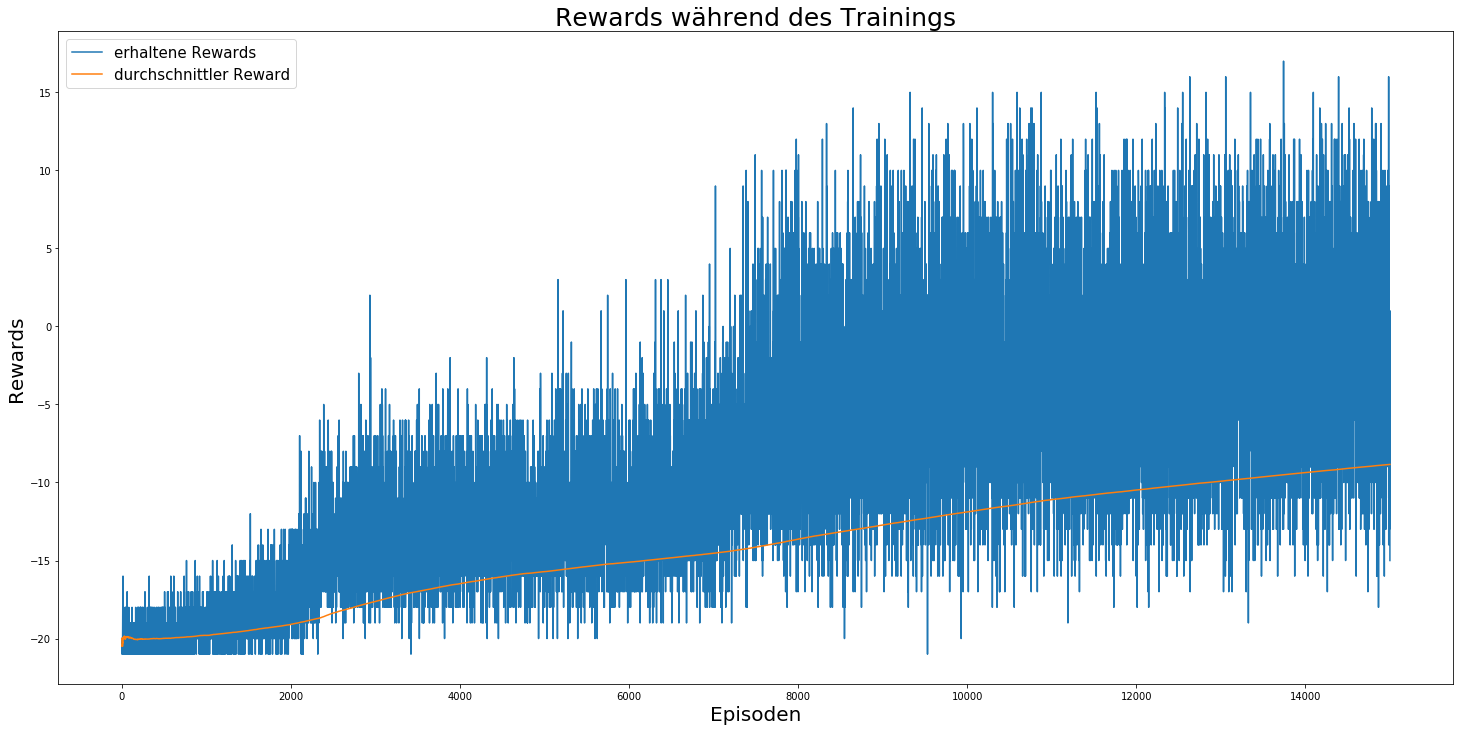

In [29]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [30]:
!ls "WEIGHTS/"

Pong-v0_DQN_Ep_10883.h5  Pong-v0_DQN_Ep_6589.h5      Pong-v0_TARGET_Ep_2945.h5
Pong-v0_DQN_Ep_13722.h5  Pong-v0_DQN_Ep_7569.h5      Pong-v0_TARGET_Ep_4308.h5
Pong-v0_DQN_Ep_14840.h5  Pong-v0_DQN_Ep_7861.h5      Pong-v0_TARGET_Ep_5221.h5
Pong-v0_DQN_Ep_2945.h5	 Pong-v0_TARGET_Ep_10883.h5  Pong-v0_TARGET_Ep_6589.h5
Pong-v0_DQN_Ep_4308.h5	 Pong-v0_TARGET_Ep_13722.h5  Pong-v0_TARGET_Ep_7569.h5
Pong-v0_DQN_Ep_5221.h5	 Pong-v0_TARGET_Ep_14840.h5  Pong-v0_TARGET_Ep_7861.h5


In [23]:
# Gewichte laden
WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
DQN.load_weights(filepath=WEIGHTS_PATH)

In [31]:
# Spielen
EPISODES = 10

for episode in range(EPISODES):
    state = env.reset()
    done = False
    EPISODE_REWARD = 0.0
    while not done:
        env.render()
        action = np.argmax(DQN(state))
        state, reward, done, _ = env.step(action)
        EPISODE_REWARD += reward

    if done:
        print("Episode:", episode+1, "\tReward:", EPISODE_REWARD)

ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    

# Rendering a Game

KeyboardInterrupt: 

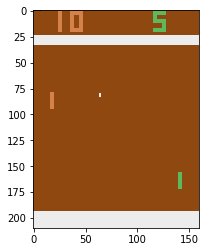

In [38]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(10):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)